# **EPL448 Classification Project**

**Authors**: Dimitrios Chatzigiannis - UC1064853, Konstantinos Sofokleous - UC1064624  
**Course**: EPL448 - Data Mining on the Web  
**Semester**: Spring 2025  

---

The goal of this project is to **build a predictive model** that identifies customers who are most likely to respond positively to a marketing campaign. Using the `Response` variable as the target (where `1` indicates a customer accepted the offer and `0` indicates they did not), the model will learn from historical customer data to make informed predictions.

This involves analysing various features such as:

- **Demographic data** (e.g. Age, Income, Education, Marital Status)  
- **Customer behaviour** (e.g. Product spending, Website visits, Deal usage)  
- **Campaign history** (e.g. Acceptance of previous offers)  
- **Engagement metrics** (e.g. Recency, Seniority)

The workflow consists of two main modelling stages:

1. **Exploratory Evaluation Phase**  
   8 classifiers (XGBoost, Random Forest, SVC, etc.) are evaluated across 10 different pre-processed dataset versions using 10-fold cross-validation. Each model is scored using weighted F1, Precision, Recall, and Accuracy, though **only the F1 score is used** for selecting top performers.

2. **Refined Tuning Phase (Pipelines + GridSearchCV)**  
   The top 3 classifiers and top 3 dataset versions from the previous phase are automatically selected, and are then used to perform hyperparameter tuning using **GridSearchCV pipelines**. Since the pipeline is slow and takes a while to run, this makes it so the three best dataset versions and three best performing classifiers are always picked.

Finally, the **best-performing model** is used to make predictions on the test set and **extract an interpretable profile of customers** predicted to respond positively. These traits (e.g. income, spending habits, common education level) are grouped into categories and presented in natural language.

---
# **Load Libraries and Dataset**

## 1. All required and relevant libraries are imported below, along with some extra options.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, make_scorer, f1_score, precision_score, make_scorer, recall_score
from IPython.display import display, HTML, Markdown
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from copy import deepcopy
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last"
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## 2. Dataset Loading and Initial Setup
- The dataset is loaded from a CSV file and the **Seaborn dark theme** is applied for consistent visual styling.
- The five `AcceptedCmp` columns (campaign responses) are **reordered** to follow a logical numerical order (`AcceptedCmp1` to `AcceptedCmp5`) for easier interpretation during analysis.
- The DataFrame is then **reconstructed** with the reordered columns while preserving the rest of the original structure.
- Finally, the Pandas display settings are updated to **show all columns** when displaying the DataFrame.

In [4]:
df = pd.read_csv("marketing_campaign.csv")
sns.set_theme(style="dark")

campaign_order = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
start_index = df.columns.get_loc('AcceptedCmp3')
tail_columns = df.columns[start_index + 5:]
initial_columns = df.columns[:start_index]
final_columns = list(initial_columns) + campaign_order + list(tail_columns)

df = df[final_columns]

---

# **Dataset Overview**


## 1. Five first observations so some examples are printed along with their values (using `df.head()`):


In [5]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


### `df.head()` Overview:

- This gives us a **quick snapshot** of the dataset's structure, which helps in gaining a quick understanding of the **data we are working with**.
- It shows how the data is organised, displaying **column names**, **data types** (categorical, numerical, dates, etc.) and a sample of the values.
- It helps identify potential issues like **out-of-order columns** (like in this dataset) or **incorrect data formats**.
- It quickly ensures that the dataset was **loaded correctly** and that the **data is intact**.
- It provides a quick look into what features/variables are available for **analysis** or **model building** in the later stages.


---

## 2. The variable type of each column (using `df.types()`):

In [6]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp1             int64
AcceptedCmp2             int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

### `df.dtypes` Overview

- This command shows the data type of each column in the dataset (e.g. integer, float, object/string, etc.).
- It helps identify which features are **numerical** and which are **categorical**/**text-based**.
- It is useful when determining how we are going to **pre-process** the data. 
- It reveals if any columns were incorrectly read (e.g. a numerical column showing as object due to formatting issues).

---

## 3. The amount of missing values from each column (using `df.isnull().sum()`):

In [7]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp1            0
AcceptedCmp2            0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

### `df.isnull().sum()` Overview:

- This command is used to **detect missing values** in the dataset.
- It checks each column and returns the **total number of null (NaN)** values per column/feature.
- It helps identify **data quality issues** that could impact analysis or model performance.

---

# **Dataset Variable Analysis**


### 1. **ID**
- Customer's unique ID number.
- Type: *Integer*
- Values: Unique values (5524, 2174, ...)

### 2. **Year_Birth**
- Customer's year of birth.
- Type: *Integer*
- Values: Between 1900 and 2000 (used to calculate age).

### 3. **Education**
- Customer's highest education level.
- Type: *Categorical*
- Possible values: `Basic`, `2n Cycle`, `Graduation`, `Master`, `PhD`
  
### 4. **Marital_Status**
- Customer's current marital status.
- Type: *Categorical*
- Possible values: `Single`, `Together`, `Married`, `Divorced`, `Widow`, Other(`Alone`,`Absurd`,`YOLO`).

### 5. **Income**
- Customer's yearly household income.
- Type: *Float*
- Values: Numeric values (26646.0, 58138.0, ...)

### 6. **Kidhome**
- Number of children in the household.
- Type: *Integer*
- Values: 0, 1, or 2, but can be more.

### 7. **Teenhome**
- Number of teenagers in the household.
- Type: *Integer*
- Values: 0, 1, or 2, but can be more.

### 8. **Dt_Customer**
- Date when the customer joined the company.
- Type: *Date (String initially)*
- Values: e.g. `04-09-2012`, `10-02-2014`, etc.

### 9. **Recency**
- Number of days since the last purchase.
- Type: *Integer*
- Values: 0 (very recent) to 99 (not recent)

### 10. **MntWines**
- Amount spent on wine in the last 2 years.
- Type: *Integer*
- Values: e.g. 11, 426, 635

### 11. **MntFruits**
- Amount spent on fruits in the last 2 years.
- Type: *Integer*
- Values: e.g. 1, 49, 88

### 12. **MntMeatProducts**
- Amount spent on meat in the last 2 years.
- Type: *Integer*
- Values: e.g. 6, 127, 546

### 13. **MntFishProducts**
- Amount spent on fish in the last 2 years.
- Type: *Integer*
- Values: e.g. 2, 111, 172

### 14. **MntSweetProducts**
- Amount spent on sweets in the last 2 years.
- Type: *Integer*
- Values: e.g. 1, 21, 88

### 15. **MntGoldProds**
- Amount spent on gold products in the last 2 years.
- Type: *Integer*
- Values: e.g. 5, 42, 88

### 16. **NumDealsPurchases**
- Number of purchases made with a discount.
- Type: *Integer*
- Values: e.g. 1, 2, 3

### 17. **NumWebPurchases**
- Number of purchases made through the company’s website.
- Type: *Integer*
- Values: e.g. 1, 8

### 18. **NumCatalogPurchases**
- Number of purchases made using a catalogue.
- Type: *Integer*
- Values: e.g. 0, 1, 10

### 19. **NumStorePurchases**
- Number of purchases made directly in stores.
- Type: *Integer*
- Values: e.g. 2, 4, 10

### 20. **NumWebVisitsMonth**
- Number of visits to the company’s website in the last month.
- Type: *Integer*
- Values: e.g. 2, 5, 7

### 21. **AcceptedCmp1**
- Whether the customer accepted the 1st campaign.
- Type: *Binary (Integer)*
- Values: 0 = No, 1 = Yes

### 22. **AcceptedCmp2**
- Whether the customer accepted the 2nd campaign.
- Type: *Binary (Integer)*
- Values: 0 = No, 1 = Yes

### 23. **AcceptedCmp3**
- Whether the customer accepted the 3rd campaign.
- Type: *Binary (Integer)*
- Values: 0 = No, 1 = Yes

### 24. **AcceptedCmp4**
- Whether the customer accepted the 4th campaign.
- Type: *Binary (Integer)*
- Values: 0 = No, 1 = Yes

### 25. **AcceptedCmp5**
- Whether the customer accepted the 5th campaign.
- Type: *Binary (Integer)*
- Values: 0 = No, 1 = Yes

### 26. **Complain**
- Whether the customer has complained in the last 2 years.
- Type: *Binary (Integer)*
- Values: 0 = No, 1 = Yes

### 27. **Z_CostContact**
- Constant feature with the cost of campaign contact.
- Type: *Integer*
- Values: Always 3 (no variability)

### 28. **Z_Revenue**
- Constant feature with revenue from the campaign.
- Type: *Integer*
- Values: Always 11 (no variability)

### 29. **Response**
- Whether the customer accepted the last campaign.
- Type: *Binary (Integer)*
- Values: 0 = No, 1 = Yes

---

# **Dataset Summarised Statistics**

In [8]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.064286,0.013393,0.072768,0.074554,0.072768,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.245316,0.114976,0.259813,0.262728,0.259813,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


### `df.describe()` Overview

- This generates **descriptive statistics** for all **numerical columns** in the dataset.
- These metrics include:
  - **count**: number of non-null entries
  - **mean**: average value
  - **std**: standard deviation (shows spread of the data)
  - **min / max**: lowest and highest values
  - **25% / 50% / 75%**: percentiles (also called quartiles)

- This helps in understanding the **distribution** of each numerical feature.
- It helps in detecting **outliers** or **abnormal values**.
- It helps in assessing whether **scaling or transformation** might be needed.
- It helps in spotting **data quality issues** like strange values or skewed distributions.

---

# **General Insights from Exploratory Analysis**

- The dataset contains **2,240 customer records** with a diverse range of attributes including demographic information, spending behaviour, and marketing campaign responses.
- **No missing values** were found in all columns besides the `Income` field, which has a small number of null entries. This will need to be addressed during the pre-processing phase.
- The `Year_Birth` column ranges from **1893 to 1996**, which likely includes **outliers** (e.g., very old birth years) that could skew age-based analysis.
- The `Education` and `Income` fields may be **positively correlated**, and these features could be important when profiling high-value customers.
- The variables `Z_CostContact` and `Z_Revenue` have **constant values (3 and 11 respectively)** across all entries and provide no useful information for modelling, so they can likely be dropped.
- Spending-related columns (e.g. `MntWines`, `MntFruits`, `MntMeatProducts`, etc.) show **wide ranges** with many **low minimums and high maximums**, suggesting **highly variable spending habits** among customers.
- The variables show that **no column is of datetime type yet**, so we might want to convert date-related fields where needed (e.g. `Dt_Customer`).
- The target variable `Response` (whether a customer accepted the last campaign) appears to be **imbalanced**, with a minority of customers accepting offers. This class imbalance may affect classification performance and would likely require handling.
- Most campaign acceptance variables (`AcceptedCmp1` through `AcceptedCmp5`) and `Response` have **low average values** (close to 0), suggesting that **most customers do not accept or respond positively to campaigns**.
- The `Complain` column also shows very low values, indicating that **very few customers filed complaints**, but analysing those who did complain might reveal useful patterns in product dissatisfaction or poor customer experience.
- Features like `Kidhome` and `Teenhome` generally have small possible value ranges (0–2), making them suitable for **categorical grouping** or creating a single `Children` feature.
- `Income` values show a **large spread**, with some extreme outliers (e.g., 666,666), which could skew the model. These outliers might need to be handled with scaling or winsorisation.
- The `Recency` variable ranges from **0 to 99**, where lower values indicate **more recent purchases**. This feature could be a strong indicator of current engagement and could correlate with responsiveness to campaigns.
- The `NumWebVisitsMonth` variable has a wide range, indicating variability in online engagement. Customers with **high website visits but low purchase counts** might be interested but unconvinced—potentially valuable targets for marketing.
- The presence of rare categories in variables like `Marital_Status` (e.g., “YOLO”, “Absurd”) may require **grouping into an "Other" category** to simplify modelling and prevent noise.
- All features have appropriate data types (integers, floats, or strings), with only `Education`, `Marital_Status`, and `Dt_Customer` as **non-numeric**. Specifically, `Dt_Customer` should be **converted from string to datetime** for variable consistency.


---

# **Visual Exploration of Key Variables**

## 1. Age Distribution Visualised: 
- The first graph visualises the **age distribution** of customers. It shows that most customers are between 40 and 60 years old, which **can guide age-targeted marketing strategies**.
- The second graph compares campaign responses (yes/no) across age brackets. It highlights that the 40–59 age group has **the highest number of respondents**, indicating **stronger engagement in that segment**.

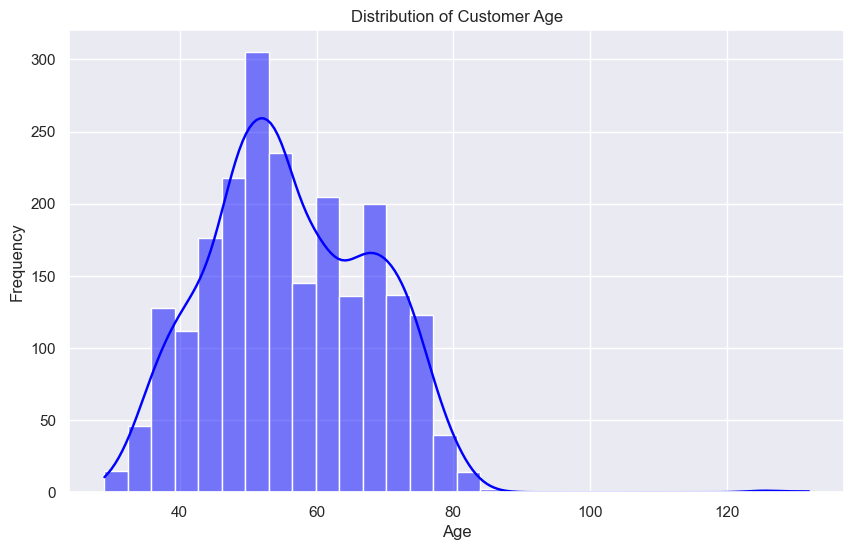

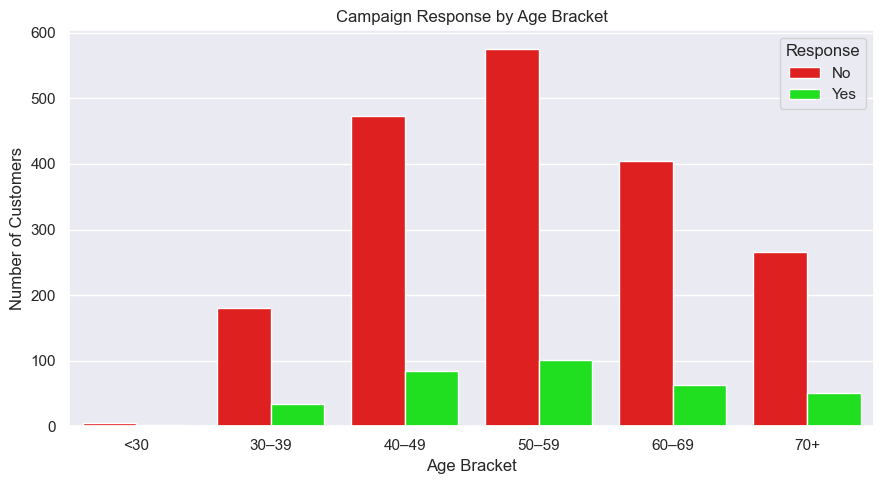

In [9]:
# 1st Graph
df['Age'] = 2025 - df['Year_Birth']     # This column is kept in the final DataFrame 
plt.figure(figsize=(10,6))
sns.histplot(df['Age'], bins=30, kde=True, color='#0000ff', line_kws={'linewidth': 1.75})
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2nd Graph
age_bins = [0, 30, 40, 50, 60, 70, 100]
age_labels = ['<30', '30–39', '40–49', '50–59', '60–69', '70+']
age_binned = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
age_response_counts = pd.DataFrame({'Age_Bracket': age_binned, 'Response': df['Response']}).groupby(['Age_Bracket', 'Response'], observed=True).size().reset_index(name='Count')

plt.figure(figsize=(9, 5))
ax = sns.barplot(data=age_response_counts, x='Age_Bracket', y='Count', hue='Response', palette={0: '#ff0000', 1: '#00ff00'})
plt.title('Campaign Response by Age Bracket')
plt.xlabel('Age Bracket')
plt.ylabel('Number of Customers')
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No' if label == '0' else 'Yes' for label in labels]
plt.legend(handles, new_labels, title='Response')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## 2. Income Distribution Visualised: 
- The first graph visualises the overall **distribution of customer income** using a histogram with a KDE (Kernel Density Estimation) line. This helps us understand the **general income range** of customers and highlights any **outliers** or skewness in the distribution. Most customers earn between **€20,000 and €80,000**, while a small number of individuals have significantly higher incomes, resulting in a **right-skewed distribution**. This helps identify common income brackets and detect any extreme outliers, which may require special handling during preprocessing. In this example, the KDE line flattens beyond €100,000, indicating the presence of **extreme outliers**, such as the customer with an income above €600,000.
- The second graph groups customers into **income brackets** (e.g., 0–20K, 20K–40K, ..., 100K+) and counts how many fall into each group. It provides a **categorical breakdown** of income ranges and reveals the **most common income segments**. The majority of customers belong to the **40K–60K** and **20K–40K** brackets, making them the dominant income categories in the dataset. 

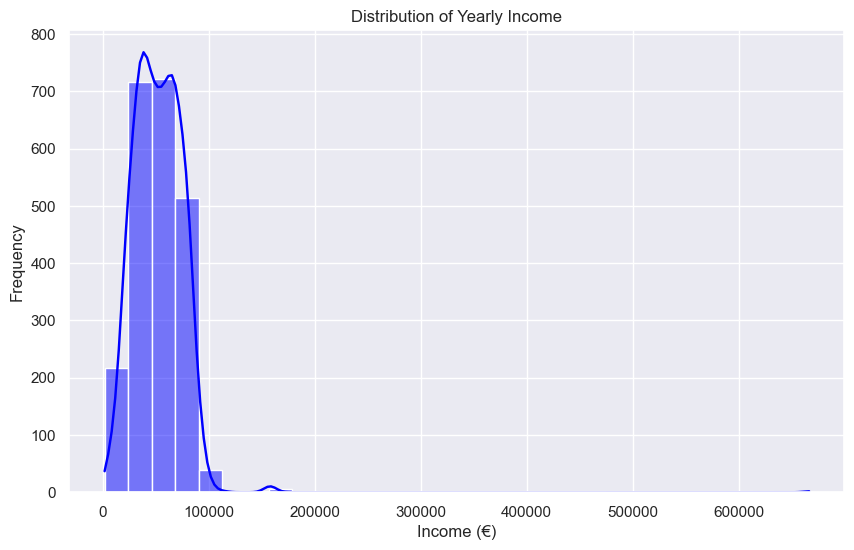

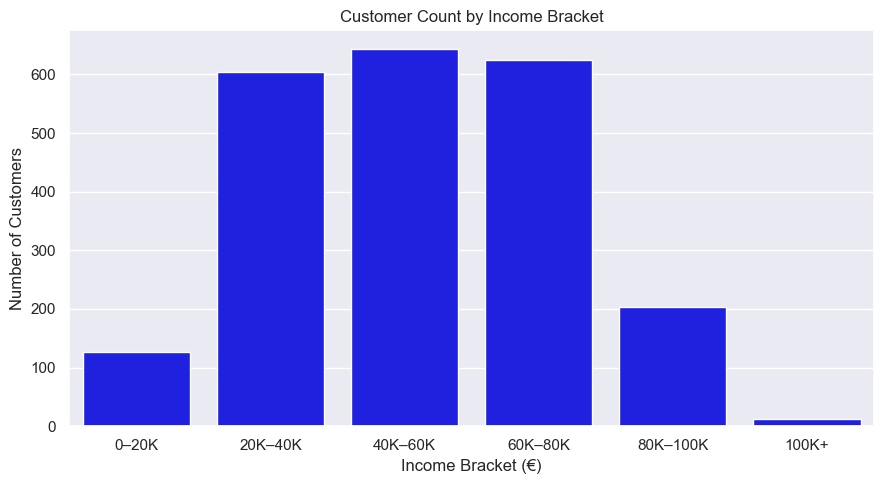

In [10]:
# 1st Graph
plt.figure(figsize=(10,6))
sns.histplot(df['Income'].dropna(), bins=30, kde=True, color='#0000ff', line_kws={'linewidth': 1.75})
plt.title('Distribution of Yearly Income')
plt.xlabel('Income (€)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2nd Graph
income_bins = [0, 20000, 40000, 60000, 80000, 100000, np.inf]
income_labels = ['0–20K', '20K–40K', '40K–60K', '60K–80K', '80K–100K', '100K+']

income_binned = pd.cut(df['Income'], bins=income_bins, labels=income_labels)
income_counts = income_binned.value_counts().sort_index()

plt.figure(figsize=(9,5))
sns.barplot(x=income_counts.index, y=income_counts.values, color='#0000ff')
plt.title('Customer Count by Income Bracket')
plt.xlabel('Income Bracket (€)')
plt.ylabel('Number of Customers')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 3. Spending by Product Category Visualised:
- The first graph displays the **total amount spent** by all customers in each product category over the past two years, which reveals that **Wine** is the most purchased product overall, followed by **Meat Products** and **Gold Products**. Categories such as **Fruits**, **Fish**, and **Sweets** show lower total spending, indicating they may not be primary drivers of revenue. This chart helps identify which product lines are generating the **most income for the company**, providing insights into popular or high-value segments.

- This second graph, which is a boxplot, illustrates the **spread of individual customer spending** across the same product categories. It shows the **median** spend (middle line), the **interquartile range (IQR)** (the box) and the **Outliers**, which are customers who spent significantly more than others. This confirms that while **Wine** is popular overall, it also has **high variance and many outliers**, meaning a few customers spend very heavily on it. Categories like **Fruits** and **Sweets** show **tight distributions and lower medians**, indicating more consistent, modest spending.

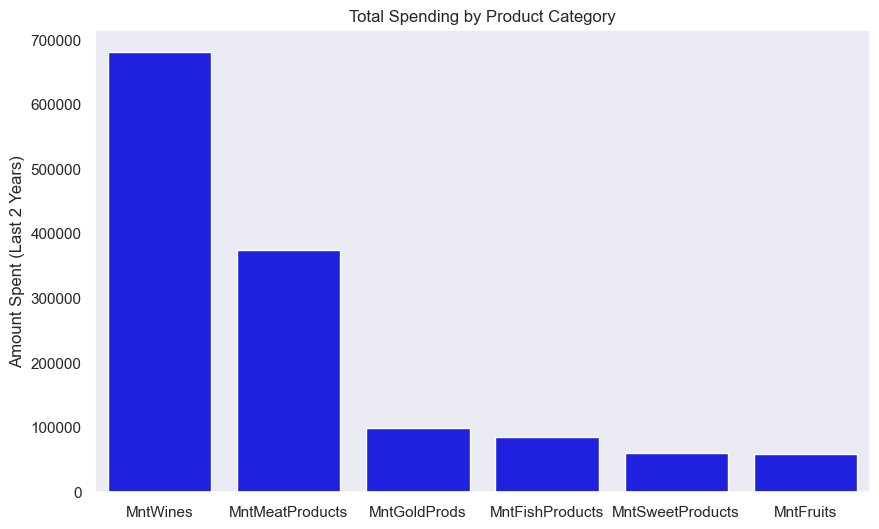

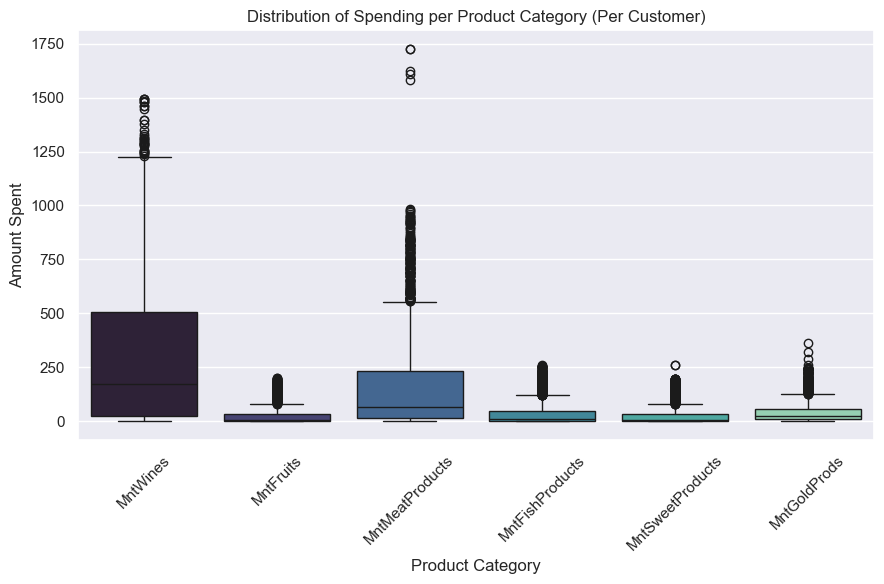

In [11]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# 1st Graph
spending_sums = df[spending_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=spending_sums.index, y=spending_sums.values, color='#0000ff')
plt.title("Total Spending by Product Category")
plt.ylabel("Amount Spent (Last 2 Years)")
plt.xlabel("")
plt.show()

# 2nd Graph
mako_edited = sns.color_palette("mako", n_colors=len(spending_cols))[:len(spending_cols)]

plt.figure(figsize=(9, 6))
sns.boxplot(data=df[spending_cols], palette=mako_edited)
plt.title("Distribution of Spending per Product Category (Per Customer)")
plt.ylabel("Amount Spent")
plt.xlabel("Product Category")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 4. Campaign Response Rates & Number of Accepted Campaigns Visualised: 
- The first graph shows the **acceptance rates** of the five marketing campaigns and the final response. This allows us to quickly compare **the effectiveness** of different campaigns and **understand how receptive customers are** to marketing efforts.
- The second graph visualises the number of customers who accepted (`Yes`) or rejected (`No`) each of the five previous campaigns and the final campaign. Unlike the first graph, which shows percentage acceptance, this chart shows **absolute counts**, helping identify which campaigns had the **most engagement overall**. It also highlights that customers could accept **multiple campaigns**, which explains why the total number of responses exceeds the number of customers.

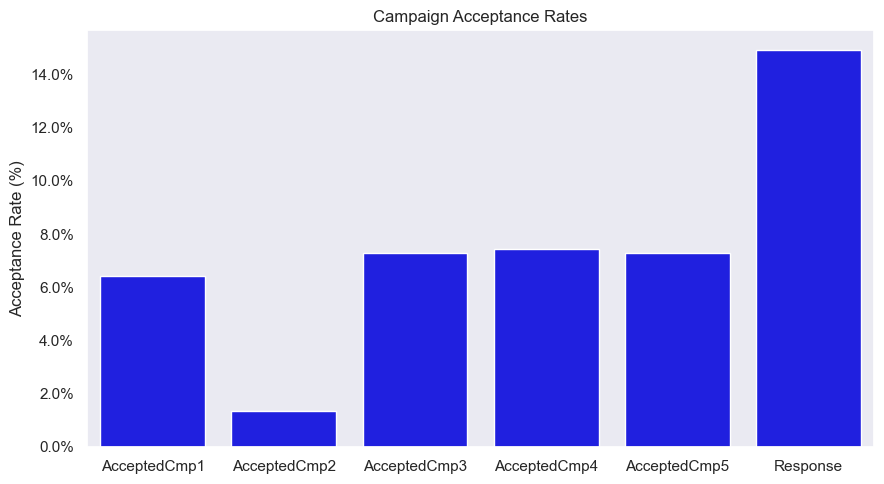

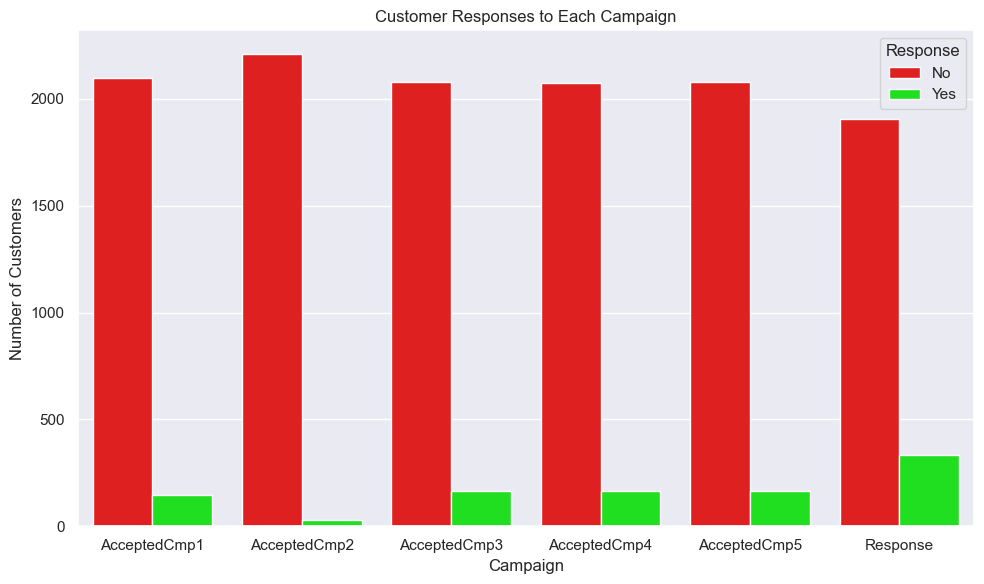

In [12]:
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
response_palette = {0: '#ff0000', 1: '#00ff00'}

# 1st Graph
total_customers = len(df)
campaign_rates = df[campaign_cols].sum() / total_customers

plt.figure(figsize=(9, 5))
sns.barplot(x=campaign_rates.index, y=campaign_rates.values, color='#0000ff')
plt.title("Campaign Acceptance Rates")
plt.ylabel("Acceptance Rate (%)")
plt.xlabel("")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(False)
plt.tight_layout()
plt.show()

# 2nd Graph
df_melted = df[campaign_cols].melt(var_name='Campaign', value_name='Accepted')

plt.figure(figsize=(10, 6))
sns.countplot(data=df_melted, x='Campaign', hue='Accepted', palette=response_palette)
plt.title('Customer Responses to Each Campaign')
plt.xlabel('Campaign')
plt.ylabel('Number of Customers')
plt.legend(title='Response', labels=['No', 'Yes'])
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## 5. Total Spending by Product Type & Average Spending per Customer and Number of Children: 
- The first graph visualises the **total amount spent** by all customers across different product categories, segmented by the number of children (both kids and teens) in the household (`Total_Kids`). Families with **3 or more children** are into a single **"3+"** category, since very few exist in the dataset. We can observe that households with **no children** generally contribute the most to total spending, especially on **wines** and **meat products**, while spending drops slightly in households with more children.

- The second graph shows the **average amount spent per customer** in each product category, again segmented by number of children in the household. This helps identify whether families with children spend more or less **per person** compared to those without. The trend reveals that customers **without children** tend to spend more on luxury items like **wines and gold products**, while those with children show slightly lower average spending in most categories.

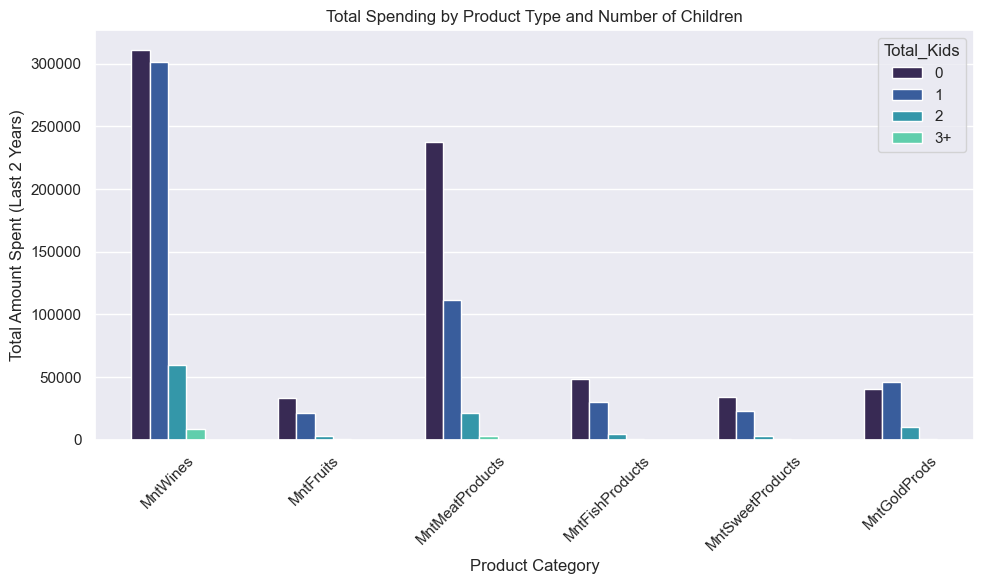

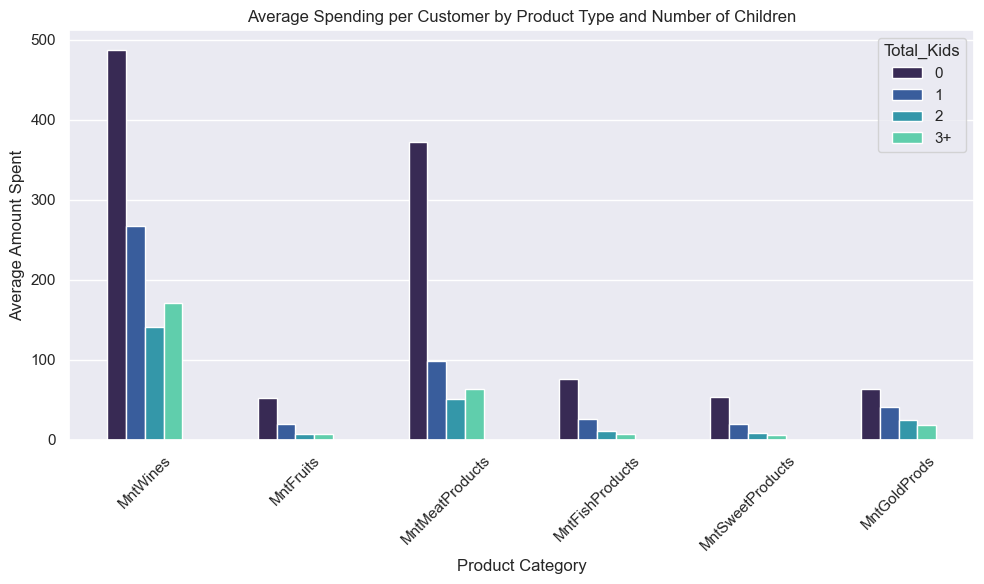

In [13]:
kids_group = (df['Kidhome'] + df['Teenhome']).apply(lambda x: str(x) if x < 3 else '3+')
unique_kids = sorted(kids_group.unique(), key=lambda x: int(x[0]) if x[0].isdigit() else 9)

palette = sns.color_palette("mako", n_colors=len(unique_kids))
mako_edited = palette[:len(unique_kids)]

# 1st Graph
total_spending_by_kids = df.assign(Total_Kids=kids_group).groupby('Total_Kids')[spending_cols].sum().T
total_spending_by_kids = total_spending_by_kids[unique_kids]  # consistent column order

total_spending_by_kids.plot(kind='bar', figsize=(10, 6), color=mako_edited)
plt.title('Total Spending by Product Type and Number of Children')
plt.ylabel('Total Amount Spent (Last 2 Years)')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 2nd Graph
avg_spending_by_kids = df.assign(Total_Kids=kids_group).groupby('Total_Kids')[spending_cols].mean().T
avg_spending_by_kids = avg_spending_by_kids[unique_kids]

avg_spending_by_kids.plot(kind='bar', figsize=(10, 6), color=mako_edited)
plt.title('Average Spending per Customer by Product Type and Number of Children')
plt.ylabel('Average Amount Spent')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 6. Education Level vs Response Rate & Response Count by Education Level: 
- The first bar chart helps identify if educational background **influences the likelihood of responding to a campaign**. It provides insight into **which education groups are more receptive** to marketing offers.
- The second plot displays the number of customers who **responded positively (Yes)** or **negatively (No)** to the last marketing campaign, grouped by their **education level**. 

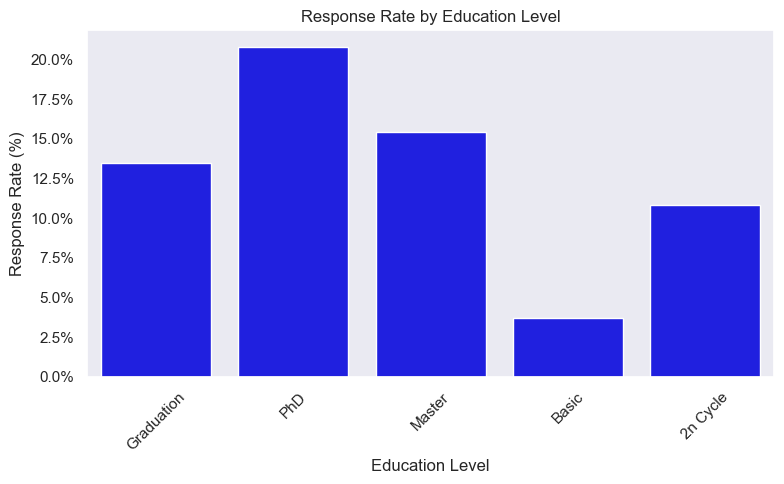

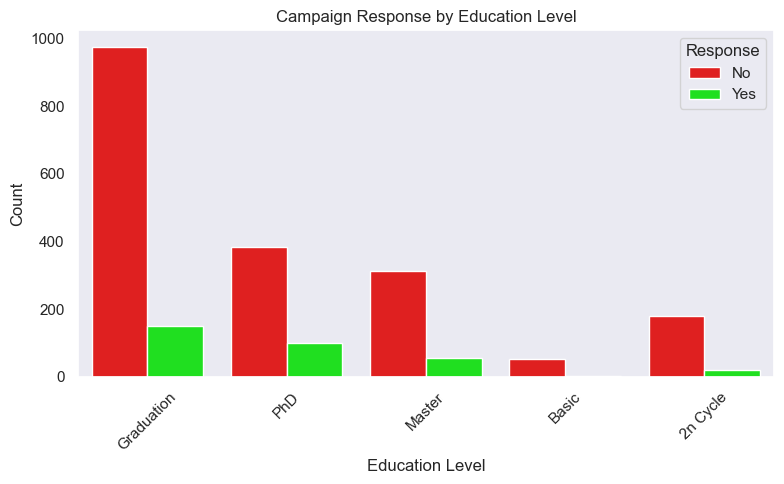

In [14]:
# 1st Graph
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Education', y='Response', estimator=np.mean, errorbar=None, color='#0000ff')
plt.title('Response Rate by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Response Rate (%)')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(False) 
plt.tight_layout()
plt.show()

# 2nd Graph
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x='Education', hue='Response', ax=ax, palette={0: '#ff0000', 1: '#00ff00'})
ax.set_title('Campaign Response by Education Level')
ax.set_xlabel('Education Level')
ax.set_ylabel('Count')
ax.legend(title='Response', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Campaign Response by Marital and Relationship Status: 
- The first graph displays the number of **positive** and **negative** campaign responses across each marital status category. The bulk of customers are `Married`, `Together`, and `Single`, with **negative** responses outnumbering positives.`Single` customers seem to show a **higher proportion** of positive responses compared to other groups, and rare categories (`Alone`, `Absurd`, `YOLO`) have **very low counts** and will be **removed or grouped** during **pre‑processing** to reduce noise.

- The second graph displays the categories **In Relationship** (includes: `Married`, `Together`) and **Not in Relationship** (includes all others). Although more customers are “In Relationship,” those **Not in Relationship** have a **higher share** of positive responses.

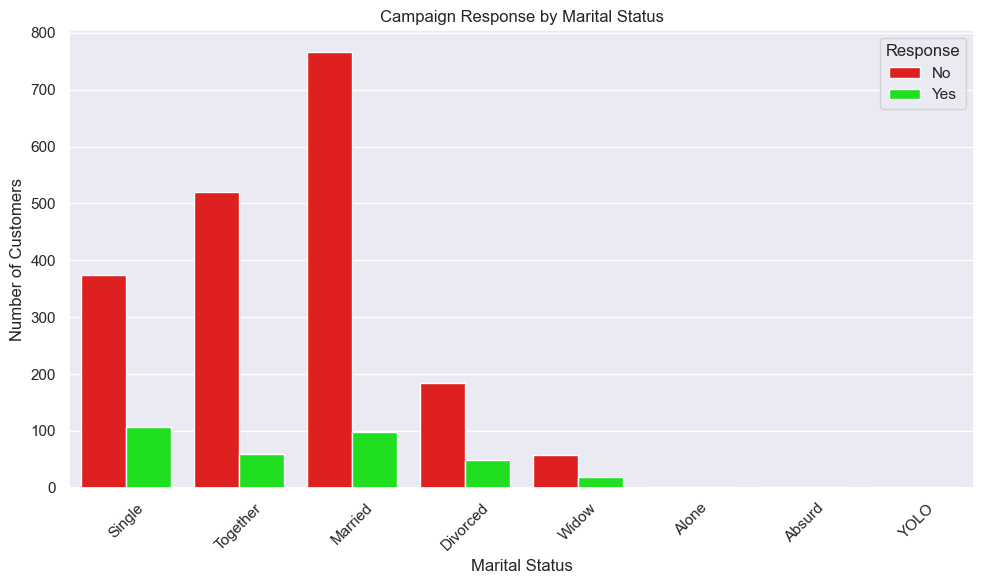

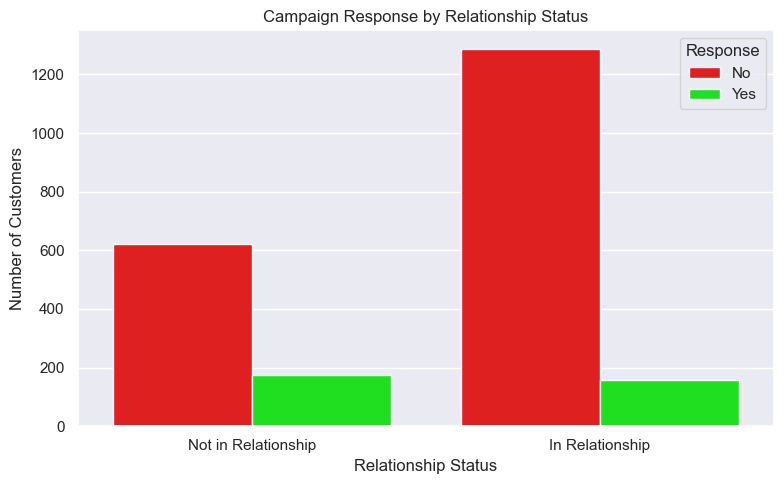

In [15]:
response_palette = {0: '#ff0000', 1: '#00ff00'}

# 1st Graph
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Marital_Status', hue='Response', palette=response_palette)
plt.title('Campaign Response by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Number of Customers')
plt.legend(title='Response', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# 2nd Graph
relationship_map = {'Married': 'In Relationship', 'Together': 'In Relationship'}

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=df['Marital_Status'].map(relationship_map).fillna('Not in Relationship'), hue='Response', palette=response_palette)
plt.title('Campaign Response by Relationship Status')
plt.xlabel('Relationship Status')
plt.ylabel('Number of Customers')
plt.legend(title='Response', labels=['No', 'Yes'])
plt.tight_layout()
plt.grid(axis='y')
plt.show()

---

# **Data Pre-processing and Cleanup**

## 1. Removal of Irrelevant or Uninformative Columns: 

From the EDA phase, we identified that the following columns do not offer any value for training purposes:
- ID: Just a unique identifier (not useful for learning)
- Z_CostContact: Constant value of 3
- Z_Revenue: Constant value of 11

In [16]:
df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'], inplace=True)

## 2. Grouping Marital Status Categories: 
From the EDA phase, we can safely deterimne that it is fine to group the different marital statuses into the **two categories** of `In Relationship` and `Not in Relationship`. Also, we identified that the following rare marital status of some customers that do not offer any value for training purposes, but **instead of being dropped**, they will be grouped into the `Not in Relationship` category.

In [17]:
df['Marital_Status'] = df['Marital_Status'].replace({
    'Married': 'In Relationship',
    'Together': 'In Relationship',
    'Single': 'Not in Relationship',
    'Divorced': 'Not in Relationship',
    'Widow': 'Not in Relationship',
    'Alone': 'Not in Relationship',
    'Absurd': 'Not in Relationship',
    'YOLO': 'Not in Relationship'
})

## 3. Standardising Education Levels:
From the EDA phase, we know that the dataset contains multiple education levels. After examining the response counts from each level, we can conclude that it is safe for them to be grouped into the following categories for simplification and improved model performance:
- `Undergraduate`: Includes "Basic" and "2n Cycle"
- `Postgraduate`: Includes "Graduation", "Master", and "PhD"

In [18]:
df['Education'] = df['Education'].replace({
    'Basic': 'Undergraduate',
    '2n Cycle': 'Undergraduate',
    'Graduation': 'Postgraduate',
    'Master': 'Postgraduate',
    'PhD': 'Postgraduate'
})

## 4. Creating the `Children` Feature:
From the EDA phase we can conclude that instead of using `Kidhome` and `Teenhome` separately, we can combine them into a single `Children` column, which reflects the total number of children in a household.

In [19]:
df['Children'] = df['Kidhome'] + df['Teenhome']
df.drop(columns=['Kidhome', 'Teenhome'], inplace=True)

## 5. Creating the `Age` Feature:
In the EDA phase, we used each customer's age directly when performing the analysis. The `Age` feature is much more versatile that the `Year_Birth` one, so the `Age` columns is created based on the current year and each customer's year of birth.

In [20]:
df['Age'] = 2025 - df['Year_Birth']

## 6. Creating the `Spending` Feature:
To summarise overall customer expenditure, we can create the new `Spending` feature, which is the sum of all product-related monetary columns over the last 2 years.

In [21]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Spending'] = df[spending_cols].sum(axis=1)

## 7. Calculating Customer Seniority:
We can compute customer seniority in days as the time since they joined the company up to a reference date (1st of May, 2025).

In [22]:
last_date = pd.to_datetime('2025-05-01')
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)
df['Seniority'] = (last_date - df['Dt_Customer']).dt.days

## 8. Renaming Columns for Clarity

To simplify our dataset and improve readability, we can rename several columns with long or complex names into shorter ones. This makes the dataset easier to work with during pre-processing, modelling, and visualisation phases.
- Product spending columns such as `MntWines`, `MntFruits`, etc., are renamed to `Wines`, `Fruits`, and so on.
- Purchase-related columns like `NumWebPurchases`, `NumCatalogPurchases`, and `NumStorePurchases` are renamed to `Web`, `Catalog`, and `Store`.

The columns were also **reordered the columns** in a more logical and intuitive sequence to enhance readability.

In [23]:
df.rename(columns={
    'Marital_Status': 'Relationship_Status',
    'MntWines': 'Wines',
    'MntFruits': 'Fruits',
    'MntMeatProducts': 'Meat',
    'MntFishProducts': 'Fish',
    'MntSweetProducts': 'Sweets',
    'MntGoldProds': 'Gold',
    'NumDealsPurchases': 'Deals',
    'NumWebPurchases': 'Web',
    'NumCatalogPurchases': 'Catalog',
    'NumStorePurchases': 'Store',
    'NumWebVisitsMonth': 'Web Visits',
    'AcceptedCmp1': 'Campaign 1',
    'AcceptedCmp2': 'Campaign 2',
    'AcceptedCmp3': 'Campaign 3',
    'AcceptedCmp4': 'Campaign 4',
    'AcceptedCmp5': 'Campaign 5',
}, inplace=True)

new_column_order = [
    'Year_Birth', 'Age', 'Education', 'Relationship_Status', 'Children', 'Income',
    'Dt_Customer', 'Seniority', 'Recency',
    'Spending', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold',
    'Deals', 'Web', 'Catalog', 'Store', 'Web Visits',
    'Campaign 1', 'Campaign 2', 'Campaign 3', 'Campaign 4', 'Campaign 5',
    'Complain', 'Response'
]

df = df[new_column_order]

## 9. Final Clean-up
We have a few duplicate or insignificant columns left, so we will drop these columns. Additionally, we can remove certain outliers that make the distribution of our DataFrame **right-skewed**.

In [24]:
df.drop(columns=['Year_Birth', 'Dt_Customer'], inplace=True)
df = df[(df['Age'] <= 100) & (df['Income'] <= 130000)]

## 10. View current DataFrame
We can now view the first 5 rows of the DataFrame after the initial pre-processing and cleanup is complete to see where our DataFrame is at.

In [25]:
df.head()

,Age,Education,Relationship_Status,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Response
0,68,Postgraduate,Not in Relationship,0,58138.0,4622,58,1617,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,71,Postgraduate,Not in Relationship,2,46344.0,4072,38,27,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,60,Postgraduate,In Relationship,0,71613.0,4271,26,776,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,41,Postgraduate,In Relationship,1,26646.0,4098,26,53,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,44,Postgraduate,In Relationship,1,58293.0,4120,94,422,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


---

# **Training and Testing**
- Now that the initial pre-processing and cleanup is complete, we will move on to the latter part of the pre-processing stage, which is preparing our data for model training and evaluation.
- For this project, we will begin with an exploratory modelling phase using the **Dataset Variations + Multiple Estimators** approach. This allows us to test a range of models and pre-processing strategies, like different encoding and scaling methods, using default hyperparameters. Doing so helps us gain insights into which combinations perform best, without committing too early to any specific pipeline.
- Once the strongest models and pre-processing configurations are identified, we will transition to a more structured approach using **Pipelines and GridSearchCV**. This ensures that pre-processing steps are consistently applied during both training and evaluation, and allows us to fine-tune hyperparameters more efficiently.
- This hybrid strategy balances **broad exploration** with **focused optimisation**, leading to better-informed decisions and more robust model performance.

In [26]:
x = df.drop(columns=['Response'])
y = df['Response']

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

## 2. Creating Multiple Dataset Versions
- To evaluate how different pre-processing strategies impact model performance, we will create **multiple versions of the dataset**, each applying a distinct combination of pre-processing techniques such as encoding and scaling.
- These dataset versions will be used to train and evaluate **a variety of estimators**, all with their **default hyperparameters**, providing a baseline performance comparison.
- We will use **cross-validation** on each version to ensure fair and consistent evaluation, helping us identify the most promising pre-processing-model combinations to pursue in the next phase.

### 2a. **Version 1** – Mean Imputation, Robust Scaling, and Ordinal Encoding

This version applies the following pre-processing strategy:

- **Numerical Features:** Missing values are filled using the **mean**, and selected features (`Age`, `Income`, `Spending`, `Seniority`) are scaled with a **Robust Scaler** to reduce the effect of outliers.
- **Categorical Features:** Missing values are imputed using the **most frequent** category, and the data is transformed using **Ordinal Encoding**.

In [27]:
x_train_V1 = x_train.copy()
x_test_V1 = x_test.copy()

num_features = x.select_dtypes(include=['int64', 'float64']).columns
cat_features = x.select_dtypes(include=['object']).columns
features_to_scale = ['Age', 'Income', 'Spending', 'Seniority']

si_num = SimpleImputer(strategy='mean')
si_num.fit(x_train_V1[num_features])

x_train_V1[num_features] = si_num.transform(x_train_V1[num_features])
x_test_V1[num_features] = si_num.transform(x_test_V1[num_features])

rs = RobustScaler()
rs.fit(x_train_V1[features_to_scale])
x_train_V1[features_to_scale] = rs.transform(x_train_V1[features_to_scale])
x_test_V1[features_to_scale] = rs.transform(x_test_V1[features_to_scale])

si_cat = SimpleImputer(strategy='most_frequent')
si_cat.fit(x_train_V1[cat_features])
x_train_V1[cat_features] = si_cat.transform(x_train_V1[cat_features])
x_test_V1[cat_features] = si_cat.transform(x_test_V1[cat_features])

ordinal_encoder = OrdinalEncoder(return_df=True, handle_unknown='value')
x_train_V1[cat_features] = ordinal_encoder.fit_transform(x_train_V1[cat_features])
x_test_V1[cat_features] = ordinal_encoder.transform(x_test_V1[cat_features])

# Testing
display(HTML("<h2 style='color:#1f77b4;'>🔵 Training Data</h2>"))
display(x_train_V1.head())  
display(HTML("<h2 style='color:#2ca02c;'>🟢 Testing Data</h2>"))
display(x_test_V1.head())

,Age,Education,Relationship_Status,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain
2033,-0.263158,1,1,1.0,0.142252,0.199857,32.0,0.883104,384.0,60.0,364.0,119.0,101.0,232.0,4.0,11.0,6.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
688,-1.000000,1,1,0.0,0.787822,-0.890792,40.0,0.970904,760.0,40.0,480.0,0.0,40.0,26.0,1.0,3.0,5.0,12.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
855,-0.473684,1,2,1.0,0.276482,0.279800,25.0,0.801429,265.0,199.0,303.0,234.0,9.0,170.0,7.0,10.0,2.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1115,-0.052632,1,1,1.0,0.610438,-0.145610,70.0,1.203675,1224.0,28.0,140.0,0.0,14.0,168.0,3.0,3.0,3.0,5.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0
449,0.894737,1,1,1.0,0.136158,-0.476802,91.0,0.033691,208.0,7.0,82.0,30.0,66.0,35.0,2.0,3.0,2.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


,Age,Education,Relationship_Status,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain
689,0.052632,1,1,0.0,0.541469,-0.239829,3.0,0.662583,260.0,86.0,559.0,63.0,9.0,67.0,1.0,4.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2040,-1.105263,1,2,0.0,-0.038694,0.191292,92.0,0.303216,202.0,47.0,197.0,55.0,42.0,149.0,1.0,5.0,4.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1696,-0.052632,2,1,2.0,-0.266356,0.833690,95.0,-0.377744,11.0,1.0,4.0,2.0,0.0,7.0,1.0,1.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1157,-0.210526,1,1,0.0,0.165830,0.613847,52.0,0.638081,258.0,105.0,239.0,237.0,172.0,9.0,1.0,7.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1621,-0.052632,1,1,1.0,-0.950458,0.505353,14.0,-0.324655,4.0,16.0,20.0,0.0,17.0,20.0,3.0,2.0,0.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2b. **Version 2** – Mean Imputation, Yeo-Johnson Transformation, and Ordinal Encoding

This version applies the following pre-processing strategy:

- **Numerical Features:** Missing values are filled using the **mean**, and selected features (`Age`, `Income`, `Spending`, `Seniority`) are transformed using the **Yeo-Johnson method**, which handles both positive and negative values while aiming to normalize the data distribution.
- **Categorical Features:** These are reused from Version 1, where missing values were imputed using the **most frequent** strategy and transformed using **Ordinal Encoding**.

In [28]:
x_train_V2 = x_train.copy()
x_test_V2 = x_test.copy()

num_features = x.select_dtypes(include=['int64', 'float64']).columns
cat_features = x.select_dtypes(include=['object']).columns

si_num = SimpleImputer(strategy='mean')
si_num.fit(x_train_V2[num_features])

x_train_V2[num_features] = si_num.transform(x_train_V2[num_features])
x_test_V2[num_features] = si_num.transform(x_test_V2[num_features])

transformer = PowerTransformer(method='yeo-johnson')

x_train_V2[features_to_scale] = transformer.fit_transform(x_train_V2[features_to_scale])
x_test_V2[features_to_scale] = transformer.transform(x_test_V2[features_to_scale])

x_train_V2[cat_features] = x_train_V1[cat_features].copy()
x_test_V2[cat_features] = x_test_V1[cat_features].copy()

# Testing
display(HTML("<h2 style='color:#1f77b4;'>🔵 Training Data</h2>"))
display(x_train_V2.head())  
display(HTML("<h2 style='color:#2ca02c;'>🟢 Testing Data</h2>"))
display(x_test_V2.head())

,Age,Education,Relationship_Status,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain
2033,-0.506194,1,1,1.0,0.243827,0.359701,32.0,1.082622,384.0,60.0,364.0,119.0,101.0,232.0,4.0,11.0,6.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
688,-1.802854,1,1,0.0,1.234017,-1.537414,40.0,1.142243,760.0,40.0,480.0,0.0,40.0,26.0,1.0,3.0,5.0,12.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
855,-0.864364,1,2,1.0,0.454348,0.498382,25.0,1.024045,265.0,199.0,303.0,234.0,9.0,170.0,7.0,10.0,2.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1115,-0.156348,1,1,1.0,0.967189,-0.240176,70.0,1.286239,1224.0,28.0,140.0,0.0,14.0,168.0,3.0,3.0,3.0,5.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0
449,1.333305,1,1,1.0,0.234205,-0.816160,91.0,0.196765,208.0,7.0,82.0,30.0,66.0,35.0,2.0,3.0,2.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


,Age,Education,Relationship_Status,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain
689,0.015703,1,1,0.0,0.862450,-0.403943,3.0,0.916424,260.0,86.0,559.0,63.0,9.0,67.0,1.0,4.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2040,-1.999248,1,2,0.0,-0.044560,0.344839,92.0,0.570950,202.0,47.0,197.0,55.0,42.0,149.0,1.0,5.0,4.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1696,-0.156348,2,1,2.0,-0.416027,1.457910,95.0,-1.476105,11.0,1.0,4.0,2.0,0.0,7.0,1.0,1.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1157,-0.417985,1,1,0.0,0.281007,1.077343,52.0,0.896235,258.0,105.0,239.0,237.0,172.0,9.0,1.0,7.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1621,-0.156348,1,1,1.0,-1.616839,0.889397,14.0,-0.912864,4.0,16.0,20.0,0.0,17.0,20.0,3.0,2.0,0.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2c. **Version 3** – Mean Imputation, Yeo-Johnson Transformation, and One-Hot Encoding

This version applies the following pre-processing strategy:

- **Numerical Features:** Missing values are filled using the **mean**, and selected features (`Age`, `Income`, `Spending`, `Seniority`) are transformed using the **Yeo-Johnson method**, as in Version 2.
- **Categorical Features:** Missing values are imputed using the **most frequent** strategy (from Version 2), and categorical variables are encoded using **One-Hot Encoding**, expanding each category into a separate binary column.

In [29]:
x_train_V3 = x_train_V2.copy()
x_test_V3 = x_test_V2.copy()

onehot_encoder = OneHotEncoder(return_df=True,
                                 handle_unknown='value',
                                )
new_cols_train = onehot_encoder.fit_transform(x_train[cat_features])

x_train_V3 = pd.concat([x_train_V3, new_cols_train], axis=1)
x_train_v3 = x_train_V3.drop(columns=cat_features)

new_cols_test = onehot_encoder.transform(x_test[cat_features])
x_test_V3 = pd.concat([x_test_V3, new_cols_test], axis=1)
x_test_V3 = x_test_V3.drop(columns=cat_features)

# Testing
display(HTML("<h2 style='color:#1f77b4;'>🔵 Training Data</h2>"))
display(x_train_V3.head())  
display(HTML("<h2 style='color:#2ca02c;'>🟢 Testing Data</h2>"))
display(x_test_V3.head())

,Age,Education,Relationship_Status,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Education_1,Education_2,Relationship_Status_1,Relationship_Status_2
2033,-0.506194,1,1,1.0,0.243827,0.359701,32.0,1.082622,384.0,60.0,364.0,119.0,101.0,232.0,4.0,11.0,6.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
688,-1.802854,1,1,0.0,1.234017,-1.537414,40.0,1.142243,760.0,40.0,480.0,0.0,40.0,26.0,1.0,3.0,5.0,12.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,1,0
855,-0.864364,1,2,1.0,0.454348,0.498382,25.0,1.024045,265.0,199.0,303.0,234.0,9.0,170.0,7.0,10.0,2.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1115,-0.156348,1,1,1.0,0.967189,-0.240176,70.0,1.286239,1224.0,28.0,140.0,0.0,14.0,168.0,3.0,3.0,3.0,5.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0,1,0
449,1.333305,1,1,1.0,0.234205,-0.816160,91.0,0.196765,208.0,7.0,82.0,30.0,66.0,35.0,2.0,3.0,2.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0


,Age,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Education_1,Education_2,Relationship_Status_1,Relationship_Status_2
689,0.015703,0.0,0.862450,-0.403943,3.0,0.916424,260.0,86.0,559.0,63.0,9.0,67.0,1.0,4.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
2040,-1.999248,0.0,-0.044560,0.344839,92.0,0.570950,202.0,47.0,197.0,55.0,42.0,149.0,1.0,5.0,4.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1696,-0.156348,2.0,-0.416027,1.457910,95.0,-1.476105,11.0,1.0,4.0,2.0,0.0,7.0,1.0,1.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0
1157,-0.417985,0.0,0.281007,1.077343,52.0,0.896235,258.0,105.0,239.0,237.0,172.0,9.0,1.0,7.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
1621,-0.156348,1.0,-1.616839,0.889397,14.0,-0.912864,4.0,16.0,20.0,0.0,17.0,20.0,3.0,2.0,0.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0


### 2d. **Version 4** – Mean Imputation, Standard Scaling, and One-Hot Encoding

This version applies the following pre-processing strategy:

- **Numerical Features:** Missing values are filled using the **mean**, and selected features (`Age`, `Income`, `Spending`, `Seniority`) are scaled using the **Standard Scaler**, which transforms them to have zero mean and unit variance.
- **Categorical Features:** Missing values are imputed using the **most frequent** category, and categorical variables are encoded using **One-Hot Encoding**, converting each category into a separate binary column.

In [30]:
x_train_V4 = x_train.copy()
x_test_V4 = x_test.copy()

num_features = x.select_dtypes(include=['int64', 'float64']).columns
cat_features = x.select_dtypes(include=['object']).columns

si_num = SimpleImputer(strategy='mean')
si_num.fit(x_train_V4[num_features])
x_train_V4[num_features] = si_num.transform(x_train_V4[num_features])
x_test_V4[num_features] = si_num.transform(x_test_V4[num_features])

ss = StandardScaler()
ss.fit(x_train_V4[features_to_scale])
x_train_V4[features_to_scale] = ss.transform(x_train_V4[features_to_scale])
x_test_V4[features_to_scale] = ss.transform(x_test_V4[features_to_scale])

si_cat = SimpleImputer(strategy='most_frequent')
si_cat.fit(x_train_V4[cat_features])
x_train_V4[cat_features] = si_cat.transform(x_train_V4[cat_features])
x_test_V4[cat_features] = si_cat.transform(x_test_V4[cat_features])

onehot_encoder = OneHotEncoder(return_df=True, handle_unknown='value')
new_cols_train = onehot_encoder.fit_transform(x_train_V4[cat_features])
x_train_V4 = pd.concat([x_train_V4, new_cols_train], axis=1).drop(columns=cat_features)
new_cols_test = onehot_encoder.transform(x_test_V4[cat_features])
x_test_V4 = pd.concat([x_test_V4, new_cols_test], axis=1).drop(columns=cat_features)

# Testing
display(HTML("<h2 style='color:#1f77b4;'>🔵 Training Data</h2>"))
display(x_train_V4.head())  
display(HTML("<h2 style='color:#2ca02c;'>🟢 Testing Data</h2>"))
display(x_test_V4.head())

,Age,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Education_1,Education_2,Relationship_Status_1,Relationship_Status_2
2033,-0.530424,1.0,0.211846,0.358578,32.0,1.085307,384.0,60.0,364.0,119.0,101.0,232.0,4.0,11.0,6.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
688,-1.732530,0.0,1.259921,-1.535645,40.0,1.227963,760.0,40.0,480.0,0.0,40.0,26.0,1.0,3.0,5.0,12.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,1,0
855,-0.873883,1.0,0.429767,0.497422,25.0,0.952605,265.0,199.0,303.0,234.0,9.0,170.0,7.0,10.0,2.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1115,-0.186965,1.0,0.971940,-0.241425,70.0,1.606165,1224.0,28.0,140.0,0.0,14.0,168.0,3.0,3.0,3.0,5.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0,1,0
449,1.358600,1.0,0.201954,-0.816634,91.0,-0.294799,208.0,7.0,82.0,30.0,66.0,35.0,2.0,3.0,2.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0


,Age,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Education_1,Education_2,Relationship_Status_1,Relationship_Status_2
689,-0.015236,0.0,0.859969,-0.405062,3.0,0.727011,260.0,86.0,559.0,63.0,9.0,67.0,1.0,4.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
2040,-1.904259,0.0,-0.081917,0.343702,92.0,0.143120,202.0,47.0,197.0,55.0,42.0,149.0,1.0,5.0,4.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1696,-0.186965,2.0,-0.451522,1.459409,95.0,-0.963287,11.0,1.0,4.0,2.0,0.0,7.0,1.0,1.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0
1157,-0.444559,0.0,0.250126,1.077590,52.0,0.687200,258.0,105.0,239.0,237.0,172.0,9.0,1.0,7.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
1621,-0.186965,1.0,-1.562153,0.889159,14.0,-0.877031,4.0,16.0,20.0,0.0,17.0,20.0,3.0,2.0,0.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0


### 2e. **Version 5** – Median Imputation, Min-Max Scaling, and Ordinal Encoding

This version applies the following pre-processing strategy:

- **Numerical Features:** Missing values are filled using the **median**, and selected features (`Age`, `Income`, `Spending`, `Seniority`) are scaled using the **Min-Max Scaler**, which transforms the values into a 0–1 range.
- **Categorical Features:** Missing values are imputed using the **most frequent** category, and the data is transformed using **Ordinal Encoding**, assigning an integer value to each category.

In [31]:
x_train_V5 = x_train.copy()
x_test_V5 = x_test.copy()

num_features = x.select_dtypes(include=['int64', 'float64']).columns
cat_features = x.select_dtypes(include=['object']).columns
features_to_scale = ['Age', 'Income', 'Spending', 'Seniority']

si_num = SimpleImputer(strategy='median')
si_num.fit(x_train_V5[num_features])
x_train_V5[num_features] = si_num.transform(x_train_V5[num_features])
x_test_V5[num_features] = si_num.transform(x_test_V5[num_features])

mm = MinMaxScaler()
mm.fit(x_train_V5[features_to_scale])
x_train_V5[features_to_scale] = mm.transform(x_train_V5[features_to_scale])
x_test_V5[features_to_scale] = mm.transform(x_test_V5[features_to_scale])

si_cat = SimpleImputer(strategy='most_frequent')
si_cat.fit(x_train_V5[cat_features])
x_train_V5[cat_features] = si_cat.transform(x_train_V5[cat_features])
x_test_V5[cat_features] = si_cat.transform(x_test_V5[cat_features])

ordinal_encoder = OrdinalEncoder(return_df=True, handle_unknown='value')
x_train_V5[cat_features] = ordinal_encoder.fit_transform(x_train_V5[cat_features])
x_test_V5[cat_features] = ordinal_encoder.transform(x_test_V5[cat_features])

# Testing
display(HTML("<h2 style='color:#1f77b4;'>🔵 Training Data</h2>"))
display(x_train_V5.head())  
display(HTML("<h2 style='color:#2ca02c;'>🟢 Testing Data</h2>"))
display(x_test_V5.head())

,Age,Education,Relationship_Status,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain
2033,0.375000,1,1,1.0,0.483768,0.609442,32.0,0.497817,384.0,60.0,364.0,119.0,101.0,232.0,4.0,11.0,6.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
688,0.125000,1,1,0.0,0.679574,0.062947,40.0,0.531957,760.0,40.0,480.0,0.0,40.0,26.0,1.0,3.0,5.0,12.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
855,0.303571,1,2,1.0,0.524481,0.649499,25.0,0.466058,265.0,199.0,303.0,234.0,9.0,170.0,7.0,10.0,2.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1115,0.446429,1,1,1.0,0.625772,0.436338,70.0,0.622469,1224.0,28.0,140.0,0.0,14.0,168.0,3.0,3.0,3.0,5.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0
449,0.767857,1,1,1.0,0.481920,0.270386,91.0,0.167527,208.0,7.0,82.0,30.0,66.0,35.0,2.0,3.0,2.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


,Age,Education,Relationship_Status,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain
689,0.482143,1,1,0.0,0.604853,0.389127,3.0,0.412068,260.0,86.0,559.0,63.0,9.0,67.0,1.0,4.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2040,0.089286,1,2,0.0,0.428886,0.605150,92.0,0.272330,202.0,47.0,197.0,55.0,42.0,149.0,1.0,5.0,4.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1696,0.446429,2,1,2.0,0.359835,0.927039,95.0,0.007543,11.0,1.0,4.0,2.0,0.0,7.0,1.0,1.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1157,0.392857,1,1,0.0,0.490920,0.816881,52.0,0.402541,258.0,105.0,239.0,237.0,172.0,9.0,1.0,7.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1621,0.446429,1,1,1.0,0.152343,0.762518,14.0,0.028186,4.0,16.0,20.0,0.0,17.0,20.0,3.0,2.0,0.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2f. **Version 6** – Mean Imputation, No Scaling, and One-Hot Encoding

This version applies the following pre-processing strategy:

- **Numerical Features:** Missing values are filled using the **mean**, and **no scaling** is applied to retain the original magnitude of the numerical values.
- **Categorical Features:** Missing values are imputed using the **most frequent** category, and the data is transformed using **One-Hot Encoding**, which creates binary columns for each category to avoid introducing ordinal relationships.

In [32]:
x_train_V6 = x_train.copy()
x_test_V6 = x_test.copy()

num_features = x.select_dtypes(include=['int64', 'float64']).columns
cat_features = x.select_dtypes(include=['object']).columns

si_num = SimpleImputer(strategy='mean')
si_num.fit(x_train_V6[num_features])
x_train_V6[num_features] = si_num.transform(x_train_V6[num_features])
x_test_V6[num_features] = si_num.transform(x_test_V6[num_features])

si_cat = SimpleImputer(strategy='most_frequent')
si_cat.fit(x_train_V6[cat_features])
x_train_V6[cat_features] = si_cat.transform(x_train_V6[cat_features])
x_test_V6[cat_features] = si_cat.transform(x_test_V6[cat_features])

onehot_encoder = OneHotEncoder(return_df=True, handle_unknown='value')
new_cols_train = onehot_encoder.fit_transform(x_train_V6[cat_features])
x_train_V6 = pd.concat([x_train_V6, new_cols_train], axis=1).drop(columns=cat_features)
new_cols_test = onehot_encoder.transform(x_test_V6[cat_features])
x_test_V6 = pd.concat([x_test_V6, new_cols_test], axis=1).drop(columns=cat_features)

# Testing
display(HTML("<h2 style='color:#1f77b4;'>🔵 Training Data</h2>"))
display(x_train_V6.head())  
display(HTML("<h2 style='color:#2ca02c;'>🟢 Testing Data</h2>"))
display(x_test_V6.head())

,Age,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Education_1,Education_2,Relationship_Status_1,Relationship_Status_2
2033,50.0,1.0,55914.0,4385.0,32.0,1260.0,384.0,60.0,364.0,119.0,101.0,232.0,4.0,11.0,6.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
688,36.0,0.0,77845.0,4003.0,40.0,1346.0,760.0,40.0,480.0,0.0,40.0,26.0,1.0,3.0,5.0,12.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,1,0
855,46.0,1.0,60474.0,4413.0,25.0,1180.0,265.0,199.0,303.0,234.0,9.0,170.0,7.0,10.0,2.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1115,54.0,1.0,71819.0,4264.0,70.0,1574.0,1224.0,28.0,140.0,0.0,14.0,168.0,3.0,3.0,3.0,5.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0,1,0
449,72.0,1.0,55707.0,4148.0,91.0,428.0,208.0,7.0,82.0,30.0,66.0,35.0,2.0,3.0,2.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0


,Age,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Education_1,Education_2,Relationship_Status_1,Relationship_Status_2
689,56.0,0.0,69476.0,4231.0,3.0,1044.0,260.0,86.0,559.0,63.0,9.0,67.0,1.0,4.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
2040,34.0,0.0,49767.0,4382.0,92.0,692.0,202.0,47.0,197.0,55.0,42.0,149.0,1.0,5.0,4.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1696,54.0,2.0,42033.0,4607.0,95.0,25.0,11.0,1.0,4.0,2.0,0.0,7.0,1.0,1.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0
1157,51.0,0.0,56715.0,4530.0,52.0,1020.0,258.0,105.0,239.0,237.0,172.0,9.0,1.0,7.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
1621,54.0,1.0,18793.0,4492.0,14.0,77.0,4.0,16.0,20.0,0.0,17.0,20.0,3.0,2.0,0.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0


### 2g. **Version 7** – Median Imputation, Log Transformation, and One-Hot Encoding

This version applies a skew-aware preprocessing strategy:

- **Numerical Features:** Missing values are imputed using the **median**, and selected numerical features (`Age`, `Income`, `Spending`, `Seniority`) are transformed using the **Log1p transformation** to reduce skewness.
- **Categorical Features:** Missing values are filled using the **most frequent category**, and One-Hot Encoding is applied to handle categorical inputs without introducing ordinal bias.

In [33]:
x_train_V7 = x_train.copy()
x_test_V7 = x_test.copy()

num_features = x.select_dtypes(include=['int64', 'float64']).columns
cat_features = x.select_dtypes(include=['object']).columns
features_to_transform = ['Age', 'Income', 'Spending', 'Seniority']

si_num = SimpleImputer(strategy='median')
si_num.fit(x_train_V7[num_features])
x_train_V7[num_features] = si_num.transform(x_train_V7[num_features])
x_test_V7[num_features] = si_num.transform(x_test_V7[num_features])

x_train_V7[features_to_transform] = np.log1p(x_train_V7[features_to_transform])
x_test_V7[features_to_transform] = np.log1p(x_test_V7[features_to_transform])

si_cat = SimpleImputer(strategy='most_frequent')
si_cat.fit(x_train_V7[cat_features])
x_train_V7[cat_features] = si_cat.transform(x_train_V7[cat_features])
x_test_V7[cat_features] = si_cat.transform(x_test_V7[cat_features])

onehot_encoder = OneHotEncoder(return_df=True, handle_unknown='value')
new_train = onehot_encoder.fit_transform(x_train_V7[cat_features])
new_test = onehot_encoder.transform(x_test_V7[cat_features])

x_train_V7 = pd.concat([x_train_V7.drop(columns=cat_features), new_train], axis=1)
x_test_V7 = pd.concat([x_test_V7.drop(columns=cat_features), new_test], axis=1)

# Testing
display(HTML("<h2 style='color:#1f77b4;'>🔵 Training Data</h2>"))
display(x_train_V7.head())
display(HTML("<h2 style='color:#2ca02c;'>🟢 Testing Data</h2>"))
display(x_test_V7.head())

,Age,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Education_1,Education_2,Relationship_Status_1,Relationship_Status_2
2033,3.931826,1.0,10.931588,8.386173,32.0,7.139660,384.0,60.0,364.0,119.0,101.0,232.0,4.0,11.0,6.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
688,3.610918,0.0,11.262488,8.295049,40.0,7.205635,760.0,40.0,480.0,0.0,40.0,26.0,1.0,3.0,5.0,12.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,1,0
855,3.850148,1.0,11.009985,8.392537,25.0,7.074117,265.0,199.0,303.0,234.0,9.0,170.0,7.0,10.0,2.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1115,4.007333,1.0,11.181918,8.358197,70.0,7.362011,1224.0,28.0,140.0,0.0,14.0,168.0,3.0,3.0,3.0,5.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0,1,0
449,4.290459,1.0,10.927879,8.330623,91.0,6.061457,208.0,7.0,82.0,30.0,66.0,35.0,2.0,3.0,2.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0


,Age,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Education_1,Education_2,Relationship_Status_1,Relationship_Status_2
689,4.043051,0.0,11.148751,8.350430,3.0,6.951772,260.0,86.0,559.0,63.0,9.0,67.0,1.0,4.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
2040,3.555348,0.0,10.815127,8.385489,92.0,6.541030,202.0,47.0,197.0,55.0,42.0,149.0,1.0,5.0,4.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1696,4.007333,2.0,10.646234,8.435549,95.0,3.258097,11.0,1.0,4.0,2.0,0.0,7.0,1.0,1.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0
1157,3.951244,0.0,10.945812,8.418698,52.0,6.928538,258.0,105.0,239.0,237.0,172.0,9.0,1.0,7.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
1621,4.007333,1.0,9.841293,8.410276,14.0,4.356709,4.0,16.0,20.0,0.0,17.0,20.0,3.0,2.0,0.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0


### 2h. **Version 8** – KNN Imputation, Robust Scaling, and One-Hot Encoding

This version applies a more sophisticated imputation method using **KNN Imputer**, which fills in missing values based on feature similarity (using nearest neighbours). It is especially useful when the dataset has complex patterns that simpler imputation strategies cannot capture.

- **Numerical Features:** Missing values are imputed using **KNN**, which relies on a distance metric. Before imputation, selected numerical features (`Age`, `Income`, `Spending`, `Seniority`) are scaled using **Robust Scaler** to minimise the influence of outliers on distance calculations.
- **Categorical Features:** Missing values are filled with the **most frequent** category. **One-Hot Encoding** is used to transform them for model compatibility.

In [34]:
x_train_V8 = x_train.copy()
x_test_V8 = x_test.copy()

num_features = x.select_dtypes(include=['int64', 'float64']).columns
cat_features = x.select_dtypes(include=['object']).columns
features_to_scale = ['Age', 'Income', 'Spending', 'Seniority']

rs = RobustScaler()
x_train_V8[features_to_scale] = rs.fit_transform(x_train_V8[features_to_scale])
x_test_V8[features_to_scale] = rs.transform(x_test_V8[features_to_scale])

knn_imputer = KNNImputer(n_neighbors=5)
x_train_V8[num_features] = knn_imputer.fit_transform(x_train_V8[num_features])
x_test_V8[num_features] = knn_imputer.transform(x_test_V8[num_features])

si_cat = SimpleImputer(strategy='most_frequent')
x_train_V8[cat_features] = si_cat.fit_transform(x_train_V8[cat_features])
x_test_V8[cat_features] = si_cat.transform(x_test_V8[cat_features])

onehot_encoder = OneHotEncoder(return_df=True, handle_unknown='value')
new_cols_train = onehot_encoder.fit_transform(x_train_V8[cat_features])
new_cols_test = onehot_encoder.transform(x_test_V8[cat_features])

x_train_V8 = pd.concat([x_train_V8.drop(columns=cat_features), new_cols_train], axis=1)
x_test_V8 = pd.concat([x_test_V8.drop(columns=cat_features), new_cols_test], axis=1)

display(HTML("<h2 style='color:#1f77b4;'>🔵 Training Data</h2>"))
display(x_train_V8.head())
display(HTML("<h2 style='color:#2ca02c;'>🟢 Testing Data</h2>"))
display(x_test_V8.head())

,Age,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Education_1,Education_2,Relationship_Status_1,Relationship_Status_2
2033,-0.263158,1.0,0.142252,0.199857,32.0,0.883104,384.0,60.0,364.0,119.0,101.0,232.0,4.0,11.0,6.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
688,-1.000000,0.0,0.787822,-0.890792,40.0,0.970904,760.0,40.0,480.0,0.0,40.0,26.0,1.0,3.0,5.0,12.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,1,0
855,-0.473684,1.0,0.276482,0.279800,25.0,0.801429,265.0,199.0,303.0,234.0,9.0,170.0,7.0,10.0,2.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1115,-0.052632,1.0,0.610438,-0.145610,70.0,1.203675,1224.0,28.0,140.0,0.0,14.0,168.0,3.0,3.0,3.0,5.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0,1,0
449,0.894737,1.0,0.136158,-0.476802,91.0,0.033691,208.0,7.0,82.0,30.0,66.0,35.0,2.0,3.0,2.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0


,Age,Children,Income,Seniority,Recency,Spending,Wines,Fruits,Meat,Fish,Sweets,Gold,Deals,Web,Catalog,Store,Web Visits,Campaign 1,Campaign 2,Campaign 3,Campaign 4,Campaign 5,Complain,Education_1,Education_2,Relationship_Status_1,Relationship_Status_2
689,0.052632,0.0,0.541469,-0.239829,3.0,0.662583,260.0,86.0,559.0,63.0,9.0,67.0,1.0,4.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
2040,-1.105263,0.0,-0.038694,0.191292,92.0,0.303216,202.0,47.0,197.0,55.0,42.0,149.0,1.0,5.0,4.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1696,-0.052632,2.0,-0.266356,0.833690,95.0,-0.377744,11.0,1.0,4.0,2.0,0.0,7.0,1.0,1.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0
1157,-0.210526,0.0,0.165830,0.613847,52.0,0.638081,258.0,105.0,239.0,237.0,172.0,9.0,1.0,7.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0
1621,-0.052632,1.0,-0.950458,0.505353,14.0,-0.324655,4.0,16.0,20.0,0.0,17.0,20.0,3.0,2.0,0.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0


### 2i. **Version 9** – Standard Scaling, One-Hot Encoding, and PCA Dimensionality Reduction

This version is derived from **Version 4**, with the following steps applied:

- **Numerical Features:** Missing values are imputed using the **mean**, and selected features (`Age`, `Income`, `Spending`, `Seniority`) are scaled using a **Standard Scaler** to normalise feature ranges.
- **Categorical Features:** Missing values are filled using the **most frequent category**, and the features are transformed using **One-Hot Encoding**.
- **Dimensionality Reduction:** After encoding, the dataset is projected onto **6 Principal Components** using **PCA**, helping reduce feature dimensionality while retaining core variance.

In [35]:
x_train_V9 = x_train_V4.copy()
x_test_V9 = x_test_V4.copy()

pca = PCA(n_components=6)
x_train_V9 = pca.fit_transform(x_train_V9)
x_test_V9 = pca.transform(x_test_V9)

display(HTML("<h2 style='color:#1f77b4;'>🔵 Training Data (PCA)</h2>"))
display(pd.DataFrame(x_train_V9).head())
display(HTML("<h2 style='color:#2ca02c;'>🟢 Testing Data (PCA)</h2>"))
display(pd.DataFrame(x_test_V9).head())

,0,1,2,3,4,5
0,175.920743,168.406437,161.583064,91.538307,9.614489,-12.893119
1,537.927399,72.273589,-98.812041,13.706089,27.934083,-14.347973
2,49.964994,185.205221,220.608126,-18.362650,-63.042598,-30.522963
3,811.728048,-431.030312,29.525433,95.334879,18.163823,19.627533
4,-125.531887,-25.888567,16.559641,-16.112368,28.868217,43.275996


,0,1,2,3,4,5
0,132.626467,375.589849,-31.636245,32.830203,-15.021491,-51.563402
1,-71.969699,86.103094,85.139697,68.536460,15.647717,42.055434
2,-342.707623,-17.225696,-20.749966,-4.220724,3.313103,46.027828
3,10.455217,133.371679,158.809439,-179.680774,0.905947,6.696287
4,-339.885210,2.653270,-5.536012,-0.002316,11.294146,-36.217838


### 2j. **Version 10** – KNN Imputation, Robust Scaling, One-Hot Encoding, and PCA

This version is based on **Version 8**, with PCA added after feature engineering:

- **Numerical Features:** Missing values are imputed using **KNN Imputer**, and selected numerical attributes (`Age`, `Income`, `Spending`, `Seniority`) are scaled using a **Robust Scaler** to reduce the influence of outliers.
- **Categorical Features:** Missing values are handled using the **most frequent strategy**, followed by **One-Hot Encoding** to represent the categories.
- **Dimensionality Reduction:** The final processed data is reduced to **6 dimensions** using **PCA**, optimising the dataset for faster and more efficient model training.

In [36]:
x_train_V10 = x_train_V8.copy()
x_test_V10 = x_test_V8.copy()

pca = PCA(n_components=6)
x_train_V10 = pca.fit_transform(x_train_V10)
x_test_V10 = pca.transform(x_test_V10)

# Testing
display(HTML("<h2 style='color:#1f77b4;'>🔵 Training Data (PCA)</h2>"))
display(pd.DataFrame(x_train_V10).head())
display(HTML("<h2 style='color:#2ca02c;'>🟢 Testing Data (PCA)</h2>"))
display(pd.DataFrame(x_test_V10).head())

,0,1,2,3,4,5
0,175.919234,168.406157,161.583749,91.537196,9.614717,-12.892973
1,537.926552,72.273060,-98.810526,13.709712,27.932257,-14.346521
2,49.962991,185.204273,220.607807,-18.364175,-63.042469,-30.521919
3,811.727544,-431.029549,29.526672,95.336120,18.163418,19.628337
4,-125.532239,-25.888747,16.559303,-16.110983,28.869144,43.275313


,0,1,2,3,4,5
0,132.624483,375.589515,-31.635913,32.831040,-15.022409,-51.562966
1,-71.969751,86.102226,85.139658,68.536120,15.647073,42.056263
2,-342.707054,-17.225727,-20.751905,-4.222765,3.313104,46.027233
3,10.453502,133.371144,158.807985,-179.683408,0.907495,6.695349
4,-339.883175,2.653838,-5.535613,-0.004793,11.294675,-36.218555


---

# **Model Selection**


## 1. Model Training Across All Dataset Versions

To evaluate model performance, **8 different classifiers** are trained across **10 dataset versions** using **10-fold cross-validation**. For each combination, the following metrics are computed:

- **F1 Score** (weighted)  
- **Precision** (weighted)  
- **Recall** (weighted)  
- **Accuracy**

The following models are evaluated using **default hyperparameters**:

- Random Forest  
- Logistic Regression  
- Support Vector Classifier (SVC)  
- XGBoost Classifier  
- AdaBoost (using the SAMME algorithm)  
- K-Nearest Neighbors (KNN)  
- Decision Tree  
- Gaussian Naive Bayes (GaussianNB)

`cross_validate` (not `cross_val_score`) is used to evaluate **all four metrics simultaneously**.

Although only the **F1 Score** is ultimately used in **ranking models** and driving **programmatic decisions** (e.g., top classifier and dataset version selection), the inclusion of **precision**, **recall**, and **accuracy** provides a **more complete view** of model behaviour. These additional metrics help diagnose trade-offs and ensure that performance is consistent across different aspects of classification, especially in potentially imbalanced scenarios.

In [37]:
featuresets = {
    'v1': x_train_V1,
    'v2': x_train_V2,
    'v3': x_train_V3,
    'v4': x_train_V4,
    'v5': x_train_V5,
    'v6': x_train_V6,
    'v7': x_train_V7,
    'v8': x_train_V8,
    'v9': x_train_V9,
    'v10': x_train_V10
}

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "GaussianNB": GaussianNB()
}

scoring = {
    'f1': make_scorer(f1_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

results = []
output_md = ""

for featureset, X_data in featuresets.items():
    output_md += f"\n### 🔹 Training on Feature Set: `{featureset}`\n"

    for clf_name, clf in classifiers.items():
        scores = cross_validate(clf, X_data, y_train, cv=10, scoring=scoring, n_jobs=-1)
        
        mean_f1 = scores['test_f1'].mean()
        mean_precision = scores['test_precision'].mean()
        mean_recall = scores['test_recall'].mean()
        mean_accuracy = scores['test_accuracy'].mean()
        
        results.append({
            'Feature Set': featureset,
            'Classifier': clf_name,
            'F1 Score': mean_f1,
            'Precision': mean_precision,
            'Recall': mean_recall,
            'Accuracy': mean_accuracy
        })

        output_md += (
            f"- **{clf_name}** → ✅ "
            f"F1: `{mean_f1:.4f}` | "
            f"Precision: `{mean_precision:.4f}` | "
            f"Recall: `{mean_recall:.4f}` | "
            f"Accuracy: `{mean_accuracy:.4f}`\n"
        )

display(Markdown(output_md))


### 🔹 Training on Feature Set: `v1`
- **Random Forest** → ✅ F1: `0.8691` | Precision: `0.8773` | Recall: `0.8872` | Accuracy: `0.8872`
- **Logistic Regression** → ✅ F1: `0.8333` | Precision: `0.8320` | Recall: `0.8572` | Accuracy: `0.8572`
- **SVC** → ✅ F1: `0.7892` | Precision: `0.7695` | Recall: `0.8486` | Accuracy: `0.8486`
- **XGBoost** → ✅ F1: `0.8679` | Precision: `0.8685` | Recall: `0.8809` | Accuracy: `0.8809`
- **AdaBoost** → ✅ F1: `0.8702` | Precision: `0.8701` | Recall: `0.8815` | Accuracy: `0.8815`
- **KNN** → ✅ F1: `0.8116` | Precision: `0.8053` | Recall: `0.8385` | Accuracy: `0.8385`
- **Decision Tree** → ✅ F1: `0.8456` | Precision: `0.8481` | Recall: `0.8441` | Accuracy: `0.8441`
- **GaussianNB** → ✅ F1: `0.8179` | Precision: `0.8351` | Recall: `0.8061` | Accuracy: `0.8061`

### 🔹 Training on Feature Set: `v2`
- **Random Forest** → ✅ F1: `0.8662` | Precision: `0.8748` | Recall: `0.8855` | Accuracy: `0.8855`
- **Logistic Regression** → ✅ F1: `0.8369` | Precision: `0.8356` | Recall: `0.8583` | Accuracy: `0.8583`
- **SVC** → ✅ F1: `0.7892` | Precision: `0.7695` | Recall: `0.8486` | Accuracy: `0.8486`
- **XGBoost** → ✅ F1: `0.8679` | Precision: `0.8685` | Recall: `0.8809` | Accuracy: `0.8809`
- **AdaBoost** → ✅ F1: `0.8698` | Precision: `0.8692` | Recall: `0.8810` | Accuracy: `0.8810`
- **KNN** → ✅ F1: `0.8126` | Precision: `0.8066` | Recall: `0.8390` | Accuracy: `0.8390`
- **Decision Tree** → ✅ F1: `0.8432` | Precision: `0.8453` | Recall: `0.8418` | Accuracy: `0.8418`
- **GaussianNB** → ✅ F1: `0.8170` | Precision: `0.8332` | Recall: `0.8056` | Accuracy: `0.8056`

### 🔹 Training on Feature Set: `v3`
- **Random Forest** → ✅ F1: `0.8680` | Precision: `0.8782` | Recall: `0.8872` | Accuracy: `0.8872`
- **Logistic Regression** → ✅ F1: `0.8442` | Precision: `0.8432` | Recall: `0.8645` | Accuracy: `0.8645`
- **SVC** → ✅ F1: `0.7892` | Precision: `0.7695` | Recall: `0.8486` | Accuracy: `0.8486`
- **XGBoost** → ✅ F1: `0.8679` | Precision: `0.8685` | Recall: `0.8809` | Accuracy: `0.8809`
- **AdaBoost** → ✅ F1: `0.8698` | Precision: `0.8692` | Recall: `0.8810` | Accuracy: `0.8810`
- **KNN** → ✅ F1: `0.8126` | Precision: `0.8066` | Recall: `0.8390` | Accuracy: `0.8390`
- **Decision Tree** → ✅ F1: `0.8434` | Precision: `0.8449` | Recall: `0.8430` | Accuracy: `0.8430`
- **GaussianNB** → ✅ F1: `0.8170` | Precision: `0.8371` | Recall: `0.8039` | Accuracy: `0.8039`

### 🔹 Training on Feature Set: `v4`
- **Random Forest** → ✅ F1: `0.8671` | Precision: `0.8772` | Recall: `0.8861` | Accuracy: `0.8861`
- **Logistic Regression** → ✅ F1: `0.8438` | Precision: `0.8453` | Recall: `0.8657` | Accuracy: `0.8657`
- **SVC** → ✅ F1: `0.7892` | Precision: `0.7695` | Recall: `0.8486` | Accuracy: `0.8486`
- **XGBoost** → ✅ F1: `0.8723` | Precision: `0.8734` | Recall: `0.8849` | Accuracy: `0.8849`
- **AdaBoost** → ✅ F1: `0.8702` | Precision: `0.8701` | Recall: `0.8815` | Accuracy: `0.8815`
- **KNN** → ✅ F1: `0.8126` | Precision: `0.8066` | Recall: `0.8390` | Accuracy: `0.8390`
- **Decision Tree** → ✅ F1: `0.8420` | Precision: `0.8431` | Recall: `0.8413` | Accuracy: `0.8413`
- **GaussianNB** → ✅ F1: `0.8185` | Precision: `0.8368` | Recall: `0.8061` | Accuracy: `0.8061`

### 🔹 Training on Feature Set: `v5`
- **Random Forest** → ✅ F1: `0.8675` | Precision: `0.8763` | Recall: `0.8855` | Accuracy: `0.8855`
- **Logistic Regression** → ✅ F1: `0.8352` | Precision: `0.8354` | Recall: `0.8594` | Accuracy: `0.8594`
- **SVC** → ✅ F1: `0.7892` | Precision: `0.7695` | Recall: `0.8486` | Accuracy: `0.8486`
- **XGBoost** → ✅ F1: `0.8679` | Precision: `0.8685` | Recall: `0.8809` | Accuracy: `0.8809`
- **AdaBoost** → ✅ F1: `0.8702` | Precision: `0.8701` | Recall: `0.8815` | Accuracy: `0.8815`
- **KNN** → ✅ F1: `0.8120` | Precision: `0.8057` | Recall: `0.8390` | Accuracy: `0.8390`
- **Decision Tree** → ✅ F1: `0.8435` | Precision: `0.8447` | Recall: `0.8430` | Accuracy: `0.8430`
- **GaussianNB** → ✅ F1: `0.8179` | Precision: `0.8351` | Recall: `0.8061` | Accuracy: `0.8061`

### 🔹 Training on Feature Set: `v6`
- **Random Forest** → ✅ F1: `0.8692` | Precision: `0.8791` | Recall: `0.8878` | Accuracy: `0.8878`
- **Logistic Regression** → ✅ F1: `0.8102` | Precision: `0.8096` | Recall: `0.8492` | Accuracy: `0.8492`
- **SVC** → ✅ F1: `0.7800` | Precision: `0.7212` | Recall: `0.8492` | Accuracy: `0.8492`
- **XGBoost** → ✅ F1: `0.8723` | Precision: `0.8734` | Recall: `0.8849` | Accuracy: `0.8849`
- **AdaBoost** → ✅ F1: `0.8702` | Precision: `0.8701` | Recall: `0.8815` | Accuracy: `0.8815`
- **KNN** → ✅ F1: `0.8116` | Precision: `0.8060` | Recall: `0.8430` | Accuracy: `0.8430`
- **Decision Tree** → ✅ F1: `0.8340` | Precision: `0.8368` | Recall: `0.8322` | Accuracy: `0.8322`
- **GaussianNB** → ✅ F1: `0.7910` | Precision: `0.8179` | Recall: `0.7733` | Accuracy: `0.7733`

### 🔹 Training on Feature Set: `v7`
- **Random Forest** → ✅ F1: `0.8743` | Precision: `0.8829` | Recall: `0.8917` | Accuracy: `0.8917`
- **Logistic Regression** → ✅ F1: `0.8399` | Precision: `0.8408` | Recall: `0.8622` | Accuracy: `0.8622`
- **SVC** → ✅ F1: `0.7892` | Precision: `0.7695` | Recall: `0.8486` | Accuracy: `0.8486`
- **XGBoost** → ✅ F1: `0.8723` | Precision: `0.8734` | Recall: `0.8849` | Accuracy: `0.8849`
- **AdaBoost** → ✅ F1: `0.8698` | Precision: `0.8692` | Recall: `0.8810` | Accuracy: `0.8810`
- **KNN** → ✅ F1: `0.8120` | Precision: `0.8057` | Recall: `0.8390` | Accuracy: `0.8390`
- **Decision Tree** → ✅ F1: `0.8437` | Precision: `0.8457` | Recall: `0.8424` | Accuracy: `0.8424`
- **GaussianNB** → ✅ F1: `0.8175` | Precision: `0.8348` | Recall: `0.8056` | Accuracy: `0.8056`

### 🔹 Training on Feature Set: `v8`
- **Random Forest** → ✅ F1: `0.8657` | Precision: `0.8752` | Recall: `0.8849` | Accuracy: `0.8849`
- **Logistic Regression** → ✅ F1: `0.8350` | Precision: `0.8319` | Recall: `0.8566` | Accuracy: `0.8566`
- **SVC** → ✅ F1: `0.7892` | Precision: `0.7695` | Recall: `0.8486` | Accuracy: `0.8486`
- **XGBoost** → ✅ F1: `0.8723` | Precision: `0.8734` | Recall: `0.8849` | Accuracy: `0.8849`
- **AdaBoost** → ✅ F1: `0.8702` | Precision: `0.8701` | Recall: `0.8815` | Accuracy: `0.8815`
- **KNN** → ✅ F1: `0.8116` | Precision: `0.8053` | Recall: `0.8385` | Accuracy: `0.8385`
- **Decision Tree** → ✅ F1: `0.8409` | Precision: `0.8435` | Recall: `0.8390` | Accuracy: `0.8390`
- **GaussianNB** → ✅ F1: `0.8185` | Precision: `0.8368` | Recall: `0.8061` | Accuracy: `0.8061`

### 🔹 Training on Feature Set: `v9`
- **Random Forest** → ✅ F1: `0.8284` | Precision: `0.8248` | Recall: `0.8555` | Accuracy: `0.8555`
- **Logistic Regression** → ✅ F1: `0.8106` | Precision: `0.8191` | Recall: `0.8555` | Accuracy: `0.8555`
- **SVC** → ✅ F1: `0.7996` | Precision: `0.8092` | Recall: `0.8509` | Accuracy: `0.8509`
- **XGBoost** → ✅ F1: `0.8334` | Precision: `0.8260` | Recall: `0.8509` | Accuracy: `0.8509`
- **AdaBoost** → ✅ F1: `0.8207` | Precision: `0.8215` | Recall: `0.8549` | Accuracy: `0.8549`
- **KNN** → ✅ F1: `0.8059` | Precision: `0.7944` | Recall: `0.8367` | Accuracy: `0.8367`
- **Decision Tree** → ✅ F1: `0.8089` | Precision: `0.8098` | Recall: `0.8090` | Accuracy: `0.8090`
- **GaussianNB** → ✅ F1: `0.8092` | Precision: `0.8085` | Recall: `0.8107` | Accuracy: `0.8107`

### 🔹 Training on Feature Set: `v10`
- **Random Forest** → ✅ F1: `0.8258` | Precision: `0.8186` | Recall: `0.8543` | Accuracy: `0.8543`
- **Logistic Regression** → ✅ F1: `0.8106` | Precision: `0.8191` | Recall: `0.8555` | Accuracy: `0.8555`
- **SVC** → ✅ F1: `0.7996` | Precision: `0.8092` | Recall: `0.8509` | Accuracy: `0.8509`
- **XGBoost** → ✅ F1: `0.8291` | Precision: `0.8210` | Recall: `0.8481` | Accuracy: `0.8481`
- **AdaBoost** → ✅ F1: `0.8207` | Precision: `0.8215` | Recall: `0.8549` | Accuracy: `0.8549`
- **KNN** → ✅ F1: `0.8059` | Precision: `0.7944` | Recall: `0.8367` | Accuracy: `0.8367`
- **Decision Tree** → ✅ F1: `0.8101` | Precision: `0.8122` | Recall: `0.8090` | Accuracy: `0.8090`
- **GaussianNB** → ✅ F1: `0.8092` | Precision: `0.8085` | Recall: `0.8107` | Accuracy: `0.8107`


## 2. Results Table: All Model Runs

After training all classifier and dataset combinations, the performance metrics are saved into a **single DataFrame**. Each row in this table represents a unique combination of:
- A **dataset version**
- A **classifier**
- The corresponding performance metrics (F1 Score, Precision, Recall, Accuracy)

In [38]:
results_df = pd.DataFrame(results)
display(results_df)

,Feature Set,Classifier,F1 Score,Precision,Recall,Accuracy
0,v1,Random Forest,0.869065,0.877261,0.887173,0.887173
1,v1,Logistic Regression,0.833297,0.832036,0.857158,0.857158
2,v1,SVC,0.789236,0.769519,0.848642,0.848642
3,v1,XGBoost,0.867929,0.868475,0.880945,0.880945
4,v1,AdaBoost,0.870223,0.870097,0.881536,0.881536
5,v1,KNN,0.811600,0.805343,0.838469,0.838469
6,v1,Decision Tree,0.845606,0.848061,0.844084,0.844084
7,v1,GaussianNB,0.817940,0.835127,0.806147,0.806147
8,v2,Random Forest,0.866249,0.874847,0.885484,0.885484
9,v2,Logistic Regression,0.836940,0.835580,0.858295,0.858295


## 3. Average Performance per Classifier

After all the results of the model evaluations are printed, the focus shifts to the **mean performance** of each classifier across all folds and datasets. This is done to give a clear view of which classifiers consistently perform well and how each model balances the F1, Precision, Recall, and Accuracy metrics. The output is sorted by **F1 Score**, the primary metric, to identify the most promising classifiers overall.

In [39]:
results_df.groupby('Classifier')[['F1 Score', 'Precision', 'Recall', 'Accuracy']].mean().sort_values(by='F1 Score', ascending=False)    

,F1 Score,Precision,Recall,Accuracy
Classifier,,,,
XGBoost,0.862357,0.861434,0.876244,0.876244
AdaBoost,0.860169,0.860093,0.876034,0.876034
Random Forest,0.860131,0.866445,0.880560,0.880560
Decision Tree,0.835525,0.837409,0.834469,0.834469
Logistic Regression,0.829972,0.831203,0.858406,0.858406
GaussianNB,0.813363,0.828394,0.803425,0.803425
KNN,0.810830,0.803669,0.838859,0.838859
SVC,0.790387,0.772618,0.849153,0.849153


## 4. Average Performance per Dataset Version

Finally, the **impact of pre-processing strategies** is printed by calculating the average performance of each **dataset version** across all classifiers. The table is sorted by **F1 Score**, which is the primary metric used.

In [40]:
results_df.groupby('Feature Set')[['F1 Score', 'Precision', 'Recall', 'Accuracy']].mean().sort_values(by='F1 Score', ascending=False)

,F1 Score,Precision,Recall,Accuracy
Feature Set,,,,
v7,0.839833,0.840257,0.856937,0.856937
v4,0.839468,0.840245,0.856658,0.856658
v3,0.839018,0.839647,0.856017,0.856017
v1,0.838112,0.838240,0.855519,0.855519
v5,0.837950,0.838178,0.855525,0.855525
v8,0.837927,0.838224,0.855029,0.855029
v2,0.837856,0.837842,0.855098,0.855098
v6,0.829810,0.826755,0.850138,0.850138
v9,0.814579,0.814149,0.840505,0.840505


---

# **Pipeline and GridSearchCV**
We will fine tune the hyperparameters of the top 3 best performing models, such that the pipelines involve the best performing featureset versions.


"Models like XGBoost, AdaBoost, and Random Forest consistently outperformed others due to their robustness to data skew and the presence of genuine outliers — particularly high-spending customers, which less robust models like Logistic Regression or SVM struggle to handle effectively. This suggests that customer behaviour is highly varied, and tree-based methods are better suited to capture this heterogeneity without requiring outlier removal."

## 1. Selecting Top Dataset Versions and Classifiers

Before proceeding with fine-tuning, we identify the best-performing dataset versions and classifiers from the exploratory evaluation phase.

- We define a `scoring` dictionary containing four common metrics (**F1 score, precision, recall, and accuracy**) all using weighted averages to account for class imbalance.
- The selection of top-performing versions and classifiers is based **only on the weighted F1 score**, as it provides the best balance between precision and recall for imbalanced datasets.
- The top 3 dataset versions (`top_versions`) and top 3 classifiers (`top_classifiers`) are extracted by grouping the evaluation results and ranking their mean F1 scores in descending order.

**Note**: While other metrics (precision, recall, accuracy) are included for completeness and interpretability, they do **not** influence the selection of top models.

In [41]:
scoring = {
    'f1': make_scorer(f1_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

top_n_versions = 3
top_versions = results_df.groupby('Feature Set')['F1 Score'] \
    .mean().sort_values(ascending=False).head(top_n_versions).index.tolist()

top_n_classifiers = 3
top_classifiers = results_df.groupby('Classifier')[['F1 Score']] \
    .mean().sort_values(by='F1 Score', ascending=False).head(top_n_classifiers).index.tolist()

print(f"✅ Top {top_n_versions} dataset versions: {top_versions}")
print(f"✅ Top {top_n_classifiers} classifiers: {top_classifiers}")

✅ Top 3 dataset versions: ['v7', 'v4', 'v3']
✅ Top 3 classifiers: ['XGBoost', 'AdaBoost', 'Random Forest']


## 2. Initialising Classifiers and Hyperparameter Grids

In preparation for the fine-tuning phase, a set of classifiers is defined along with each classifier's associated hyperparameter grids.
- The `classifier_lookup` dictionary acts as a map for each classifier to its corresponding function.
- For each classifier (except `GaussianNB` which has no tunable hyperparameters), a dedicated `param_grid` dictionary is creted that outlines the hyperparameter ranges to be explored during `GridSearchCV`.

This setup allows for dynamic retrieval of the appropriate classifier and its grid based on prior top-performing selections.

In [ ]:
classifier_lookup = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(),
    'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB()
}

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2']
}

param_grid_lr = {
    'classifier__penalty': ['l2'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['lbfgs'],
    'classifier__max_iter': [100, 200]
}

param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__gamma': [0.0, 0.1],
}

param_grid_ada = {
    'classifier__n_estimators': [50, 100, 200, 500],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

param_grid_dt = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

param_grid_lookup = {
    'Random Forest': param_grid_rf,
    'Logistic Regression': param_grid_lr,
    'SVC': param_grid_svc,
    'XGBoost': param_grid_xgb,
    'AdaBoost': param_grid_ada,
    'KNN': param_grid_knn,
    'Decision Tree': param_grid_dt,
    'GaussianNB': {}    # cannot tune hyperparameters
}

## 3. Dynamic Pre-processing Based on Feature Set Version

To support evaluation across multiple dataset variations, the `get_preprocessor` function is defined, which returns a tailored `ColumnTransformer` pipeline for each version (`v1` to `v10`).

Each version applies different combinations of:
- **Numerical transformations**: imputation (`mean`, `median`, `KNN`), scaling (`RobustScaler`, `StandardScaler`, `MinMaxScaler`), or transformations (`Yeo-Johnson`, `log1p`).
- **Categorical transformations**: using ordinal or one-hot encoding with imputation.
- Unused columns are passed through (`remainder='passthrough'`).

Note: Versions `v9` and `v10` reuse logic from earlier versions to avoid redundancy.

In [43]:
def get_preprocessor(version, num_features, cat_features, features_to_scale=None, features_to_transform=None):
    features_to_scale = list(features_to_scale) if features_to_scale is not None else []
    features_to_transform = list(features_to_transform) if features_to_transform is not None else []
    cat_features = list(cat_features) if cat_features is not None else []

    if version == 'v1':
        return ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', RobustScaler())
            ]), features_to_scale),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal', OrdinalEncoder())
            ]), cat_features)
        ], remainder='passthrough')
    elif version == 'v2':
        return ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('yeojohnson', PowerTransformer(method='yeo-johnson'))
            ]), features_to_scale),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal', OrdinalEncoder())
            ]), cat_features)
        ], remainder='passthrough')
    elif version == 'v3':
        return ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('yeojohnson', PowerTransformer(method='yeo-johnson'))
            ]), features_to_scale),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), cat_features)
        ], remainder='passthrough')
    elif version == 'v4':
        return ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), features_to_scale),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), cat_features)
        ], remainder='passthrough')
    elif version == 'v5':
        return ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler())
            ]), features_to_scale),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal', OrdinalEncoder())
            ]), cat_features)
        ], remainder='passthrough')
    elif version == 'v6':
        return ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean'))
            ]), features_to_scale),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), cat_features)
        ], remainder='passthrough')
    elif version == 'v7':
        return ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('log', FunctionTransformer(np.log1p, validate=False))
            ]), features_to_transform),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), cat_features)
        ], remainder='passthrough')
    elif version == 'v8':
        return ColumnTransformer([
            ('num', Pipeline([
                ('imputer', KNNImputer(n_neighbors=5)),
                ('scaler', RobustScaler())
            ]), features_to_scale),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), cat_features)
        ], remainder='passthrough')
    elif version == 'v9':
        return get_preprocessor('v4', num_features, cat_features, features_to_scale, features_to_transform)
    elif version == 'v10':
        return get_preprocessor('v8', num_features, cat_features, features_to_scale, features_to_transform)
    else:
        raise ValueError(f"Unknown version: {version}")

## 4. Hyperparameter Tuning with GridSearchCV

For each of the top-performing dataset versions and classifiers identified earlier, **hyperparameter tuning** is performed using `GridSearchCV`.

- A custom pipeline is created for each combination, including the appropriate **preprocessor** and classifier.
- The **hyperparameter grid** for each classifier is pulled from the predefined lookup.
- **5-fold cross-validation** is used and optimised for the **weighted F1 score** (`refit='f1'`).
- Performance metrics (F1, Precision, Recall, Accuracy) are printed for both the cross-validation and final test predictions.

The best estimator for each combination is stored in the `best_estimators` dictionary for later use and evaluation.

In [47]:
best_estimators = {}

for version in top_versions:
    for clf_name in top_classifiers:
        clf = deepcopy(classifier_lookup[clf_name])
        param_grid = param_grid_lookup.get(clf_name, {})

        label = f"{clf_name.replace(' ', '')}_{version}_pipeline"
        print(f"\n🔹 Running GridSearchCV for {label}...")

        pipeline = Pipeline([
            ('preprocessor', get_preprocessor(version, num_features, cat_features, features_to_scale, features_to_transform)),
            ('classifier', clf)
        ])

        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=5,
            scoring=scoring,
            refit='f1',
            n_jobs=-1
        )

        _ = grid.fit(x_train, y_train)
        best_estimators[label] = (grid.best_estimator_, grid)

        best_idx = grid.best_index_
        grid_results = grid.cv_results_

        print(f"- Best Parameters for {label}: {grid.best_params_}")
        print(f"- CV Scores → "
              f"F1: {grid_results['mean_test_f1'][best_idx]:.4f} | "
              f"Precision: {grid_results['mean_test_precision'][best_idx]:.4f} | "
              f"Recall: {grid_results['mean_test_recall'][best_idx]:.4f} | "
              f"Accuracy: {grid_results['mean_test_accuracy'][best_idx]:.4f}")

        y_pred = grid.predict(x_test)
        print(f"- Test Scores → "
              f"F1: {f1_score(y_test, y_pred, average='weighted'):.4f} | "
              f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f} | "
              f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f} | "
              f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


🔹 Running GridSearchCV for XGBoost_v7_pipeline...
- Best Parameters for XGBoost_v7_pipeline: {'classifier__gamma': 0.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
- CV Scores → F1: 0.8797 | Precision: 0.8823 | Recall: 0.8917 | Accuracy: 0.8917
- Test Scores → F1: 0.8665 | Precision: 0.8729 | Recall: 0.8844 | Accuracy: 0.8844

🔹 Running GridSearchCV for AdaBoost_v7_pipeline...
- Best Parameters for AdaBoost_v7_pipeline: {'classifier__learning_rate': 0.2, 'classifier__n_estimators': 500}
- CV Scores → F1: 0.8766 | Precision: 0.8857 | Recall: 0.8929 | Accuracy: 0.8929
- Test Scores → F1: 0.8579 | Precision: 0.8628 | Recall: 0.8776 | Accuracy: 0.8776

🔹 Running GridSearchCV for RandomForest_v7_pipeline...
- Best Parameters for RandomForest_v7_pipeline: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_esti

## 5. Selecting and Evaluating the Best Model

After tuning all selected pipelines, their **test set performance** is evaluated to identify the overall best-performing model.
- Each estimator is used to make predictions on the test set, and its **weighted F1 score** is computed.
- The model with the **highest F1 score on the test set** is selected as the final model (`best_model`).
- A full evaluation of this model is then printed, with both the training and testing sets using all four metrics: **F1**, **Precision**, **Recall**, and **Accuracy**.

In [52]:
best_label = None
best_f1 = -1

for label, (estimator, grid) in best_estimators.items():
    y_val_pred = estimator.predict(x_test)
    f1 = f1_score(y_test, y_val_pred, average='weighted')

    if f1 > best_f1:
        best_f1 = f1
        best_label = label

best_model, best_grid = best_estimators[best_label]

print(f"✅ Best Performing Model: {best_label} with Test F1 = {best_f1:.4f}")
print(f"✅ Best Hyperparameters: {best_grid.best_params_}")

y_train_pred = best_model.predict(x_train)
print("\n🔹 Training Scores:")
print(f"- F1: {f1_score(y_train, y_train_pred, average='weighted'):.4f} | "
      f"Precision: {precision_score(y_train, y_train_pred, average='weighted'):.4f} | "
      f"Recall: {recall_score(y_train, y_train_pred, average='weighted'):.4f} | "
      f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")

y_test_pred = best_model.predict(x_test)
print("\n🔹 Testing Scores:")
print(f"- F1: {f1_score(y_test, y_test_pred, average='weighted'):.4f} | "
      f"Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f} | "
      f"Recall: {recall_score(y_test, y_test_pred, average='weighted'):.4f} | "
      f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")


✅ Best Performing Model: XGBoost_v7_pipeline with Test F1 = 0.8665
✅ Best Hyperparameters: {'classifier__gamma': 0.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}

🔹 Training Scores:
- F1: 0.9358 | Precision: 0.9425 | Recall: 0.9410 | Accuracy: 0.9410

🔹 Testing Scores:
- F1: 0.8665 | Precision: 0.8729 | Recall: 0.8844 | Accuracy: 0.8844


---

# **Final Output: Customer Profiling from Best Model Predictions**

- As the **final step** of the project, the best-performing model is used to generate predictions on the test set.
- From these predictions, the subset of customers the model believes are most likely to respond positively to a marketing campaign is isolated.
- A detailed **customer profile** is then constructed by averaging and summarising relevant behavioural and demographic features for this group.
- These characteristics are grouped into **Demographics**, **Spending**, and **Engagement**, and are renamed using **domain-appropriate labels** (e.g., *Wines* becomes *Wine Spending*, *Web* becomes *Web Purchases*, etc.).
- Output values are formatted for interpretability:
  - **Count and age-related features** are rounded to integers.
  - **Spending and income values** are formatted in euros.
  - **Time-based metrics** (like days since last purchase) are shown as floats.

This summarised customer profile offers **actionable insights** into the types of individuals most likely to engage with future campaigns.

In [46]:
y_pred = best_model.predict(x_test)
original_test_df = x_test.copy()
original_test_df['target'] = y_test
original_test_df['predicted'] = y_pred
responding_customers = original_test_df[original_test_df['predicted'] == 1]

excluded_fields = ['Campaign 1', 'Campaign 2', 'Campaign 3', 'Campaign 4', 'Campaign 5', 'Complain']

label_replacements = {
    'Web': 'Web Purchases',
    'Catalog': 'Catalog Purchases',
    'Store': 'Store Purchases',
    'Web Visits': 'Web Visits Before Purchase',
    'Complain': 'Complaints',
    'Deals': 'Accepted Deals',
    'Gold': 'Gold Product Spending',
    'Fruits': 'Fruit Spending',
    'Wines': 'Wine Spending',
    'Meat': 'Meat Spending',
    'Fish': 'Fish Spending',
    'Sweets': 'Sweets Spending',
    'Spending': 'Total Spending',
    'Seniority': 'Customer Seniority (in days)',
    'Recency': 'Last Purchase (days ago)',
    'Income': 'Income',
    'Children': 'Number of Children'
}

int_fields = ['Age', 'Children', 'Deals', 'Web', 'Catalog', 'Store', 'Web Visits']
euro_fields = ['Income', 'Spending', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
float_fields = ['Recency', 'Seniority', 'Complain']


grouped_output = defaultdict(list)

for col in responding_customers.columns:
    if col in ['target', 'predicted'] or col in excluded_fields:
        continue

    label = label_replacements.get(col, col)
    value = responding_customers[col]

    if pd.api.types.is_numeric_dtype(value):
        avg_val = value.mean()
        if col in int_fields:
            group = 'Demographics' if col in ['Age', 'Children'] else 'Engagement'
            grouped_output[group].append(f"- {label}: {round(avg_val)}")
        elif col in euro_fields:
            grouped_output['Spending'].append(f"- {label}: €{avg_val:,.2f}")
        elif col in float_fields:
            grouped_output['Engagement'].append(f"- {label}: {avg_val:.2f}")
    else:
        mode_val = value.mode()[0]
        if col == 'Relationship_Status':
            sentence = f"- Majority are {mode_val.lower()}"
        elif col == 'Education':
            sentence = f"- Most are {mode_val} educated"
        else:
            sentence = f"- {label}: {mode_val}"
        grouped_output['Demographics'].append(sentence)

print("\nAverage profile of customers most likely to respond:")

for group in ['Demographics', 'Spending', 'Engagement', 'Miscellaneous']:
    if grouped_output[group]:
        print(f"\n🔹 {group}:")
        for line in grouped_output[group]:
            print(line)


Average profile of customers most likely to respond:

🔹 Demographics:
- Age: 53
- Most are Postgraduate educated
- Majority are not in relationship
- Number of Children: 0

🔹 Spending:
- Income: €72,533.09
- Total Spending: €1,328.25
- Wine Spending: €645.19
- Fruit Spending: €50.78
- Meat Spending: €415.66
- Fish Spending: €78.62
- Sweets Spending: €59.00
- Gold Product Spending: €79.00

🔹 Engagement:
- Customer Seniority (in days): 4452.53
- Last Purchase (days ago): 42.81
- Accepted Deals: 1
- Web Purchases: 5
- Catalog Purchases: 6
- Store Purchases: 7
- Web Visits Before Purchase: 4
